# **Magdalena Sokolowska, s32924, 2025, PJATK, I SEM, PAD Projekt zaliczeniowy** 
## <img src="https://avatars.githubusercontent.com/u/98705492?v=4" width="30" height="30"> [Github](https://github.com/magda2307)

# Analiza danych zescrapowanych z otomoto.pl dotycząca wszystkich aut, które są bezwypadkowe i na sprzedaż (warunek ustawiony podczas scrapowania).

## Niektórych kolumn podczas scrapowania nie udało się zescrapować, ale kluczowe i istotne dane są mostly pełne. Jest to dobry przykład na czyszczenie i prepowanie danych.

# Importing the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score


# Load the data
data = pd.read_csv('otomoto_cars.csv')

# Take a quick look
print(data.info())
data.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132384 entries, 0 to 132383
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   url              132384 non-null  object 
 1   name             123495 non-null  object 
 2   description      132384 non-null  object 
 3   price            131656 non-null  object 
 4   make             131653 non-null  object 
 5   model            131656 non-null  object 
 6   version          94887 non-null   object 
 7   color            131656 non-null  object 
 8   door_count       131443 non-null  float64
 9   nr_seats         126495 non-null  float64
 10  year             131656 non-null  float64
 11  generation       97538 non-null   object 
 12  fuel_type        131656 non-null  object 
 13  engine_capacity  129666 non-null  object 
 14  engine_power     131631 non-null  object 
 15  body_type        0 non-null       float64
 16  gearbox          131624 non-null  obje

door_count       nr_seats           year  body_type  transmission  \
count  131443.000000  126495.000000  131656.000000        0.0           0.0   
mean        4.761448       5.068208    2015.582290        NaN           NaN   
std         0.616589       0.702173       5.838257        NaN           NaN   
min         2.000000       1.000000    1929.000000        NaN           NaN   
25%         5.000000       5.000000    2012.000000        NaN           NaN   
50%         5.000000       5.000000    2016.000000        NaN           NaN   
75%         5.000000       5.000000    2020.000000        NaN           NaN   
max         6.000000       9.000000    2025.000000        NaN           NaN   

       new_used  registered  no_accident  
count       0.0         0.0          0.0  
mean        NaN         NaN          NaN  
std         NaN         NaN          NaN  
min         NaN         NaN          NaN  
25%         NaN         NaN          NaN  
50%         NaN         NaN          NaN  
75%         NaN         NaN          NaN  
max         NaN         NaN          NaN

# Cleaning and preparing the data

- **Remove Duplicates** – Ensures unique records.
- **Drop Missing Values** – Removes rows with critical missing data (`price`, `mileage`, `make`, etc.).
- **Drop Unnecessary Columns** – Excludes mostly empty or irrelevant fields (`no_accident`, `url`, etc.).


In [ ]:
# Data Cleaning
initial_row_count = data.shape[0]
print(f"Number of rows before cleaning: {initial_row_count}")

# duplicate rows
data.drop_duplicates(inplace=True)

# rows with missing values in critical columns
data.dropna(
    subset=['price', 'mileage', 'make', 'model', 'engine_capacity', 'engine_power', 'year', 'gearbox'],
    inplace=True
)

# columns that are mostly empty or not interesting
cols_to_drop = [
    'no_accident', 'registered', 'new_used', 'transmission', 
    'body_type', 'country_origin', 
    'name', 'description', 'url'  ]
for col in cols_to_drop:
    if col in data.columns:
        data.drop(columns=[col], inplace=True, errors='ignore')

final_row_count = data.shape[0]
print(f"Number of rows after cleaning: {final_row_count}")
rows_removed = initial_row_count - final_row_count
print(f"Number of rows removed during cleaning: {rows_removed}")

print("Head of the filtered data:")
data.head()

Number of rows before cleaning: 132384
Number of rows after cleaning: 129630
Number of rows removed during cleaning: 2754
Head of the filtered data:


price        make            model  \
0  92 000        Ford           Escape   
1  25 900        Ford  Tourneo Courier   
2  32 900     Citroën        C4 Cactus   
3  18 777  Volkswagen           Touran   
4  79 900        Audi               A8   

                                     version     color  door_count  nr_seats  \
0                  2.0 EcoBoost AWD Titanium    Czarny         5.0       NaN   
1                          1.5 TDCi Ambiente  Czerwony         5.0       5.0   
2                  1.2 PureTech Feel Edition     Biały         5.0       5.0   
3                              1.6 Trendline   Srebrny         5.0       7.0   
4  4.2 TDI DPF quattro tiptronic Langversion   Brązowy         4.0       5.0   

     year     generation fuel_type engine_capacity engine_power       gearbox  \
0  2020.0            NaN   Benzyna       1 999 cm3       242 KM  Automatyczna   
1  2016.0            NaN    Diesel       1 498 cm3        75 KM      Manualna   
2  2015.0            NaN   Benzyna       1 199 cm3        82 KM      Manualna   
3  2007.0  I (2003-2010)   Benzyna       1 595 cm3       102 KM      Manualna   
4  2011.0     D4 (2010-)    Diesel       4 134 cm3       350 KM  Automatyczna   

      mileage  
0   73 000 km  
1  180 000 km  
2  218 000 km  
3  250 500 km  
4  275 000 km

## Manufacturer preparation & cleanup

- **Remove manufacturers with too few listings**: Manufacturers below the 85th percentile are considered outliers and removed.

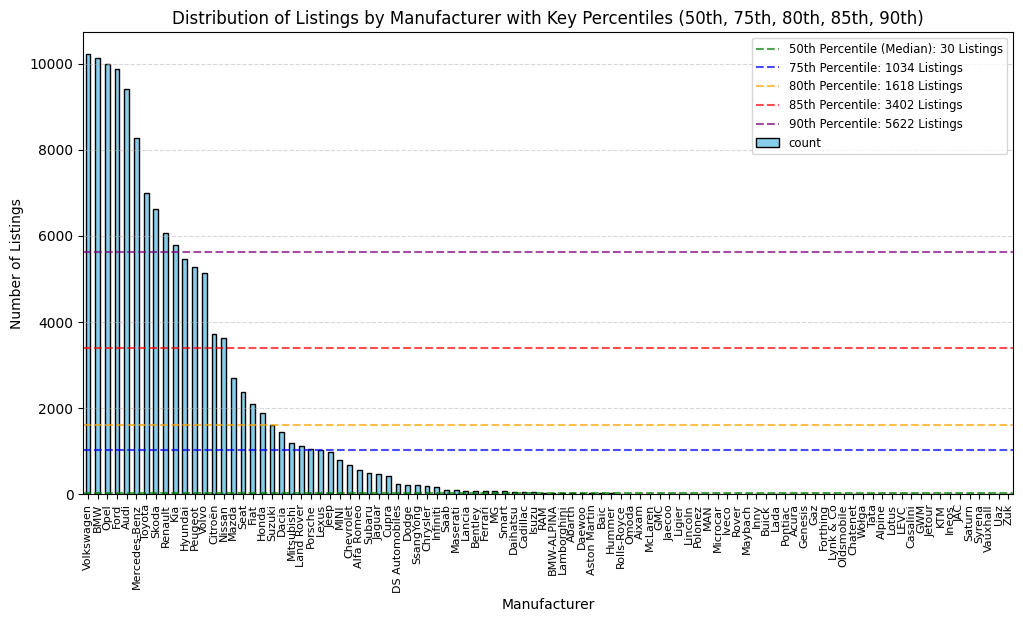

In [ ]:
manufacturer_counts = data['make'].value_counts()

selected_percentiles = {
    "50th Percentile (Median)": int(np.percentile(manufacturer_counts, 50)),
    "75th Percentile": int(np.percentile(manufacturer_counts, 75)),
    "80th Percentile": int(np.percentile(manufacturer_counts, 80)),
    "85th Percentile": int(np.percentile(manufacturer_counts, 85)),
    "90th Percentile": int(np.percentile(manufacturer_counts, 90)),
}

plt.figure(figsize=(12, 6))
manufacturer_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# percentile lines
colors = ['green', 'blue', 'orange', 'red', 'purple']
for (label, p), color in zip(selected_percentiles.items(), colors):
    plt.axhline(y=p, color=color, linestyle='--', linewidth=1.5, alpha=0.7, label=f'{label}: {p} Listings')

plt.xlabel('Manufacturer')
plt.ylabel('Number of Listings')
plt.title('Distribution of Listings by Manufacturer with Key Percentiles (50th, 75th, 80th, 85th, 90th)')
plt.xticks(rotation=90, fontsize=8)
plt.legend(loc='upper right', fontsize='small', frameon=True)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


The 50th percentile (median) is 20 listings, meaning that half of all manufacturers have 20 or fewer listings - we deal with long tail distribution.
85th percentile seems like a great choice for an outlier.

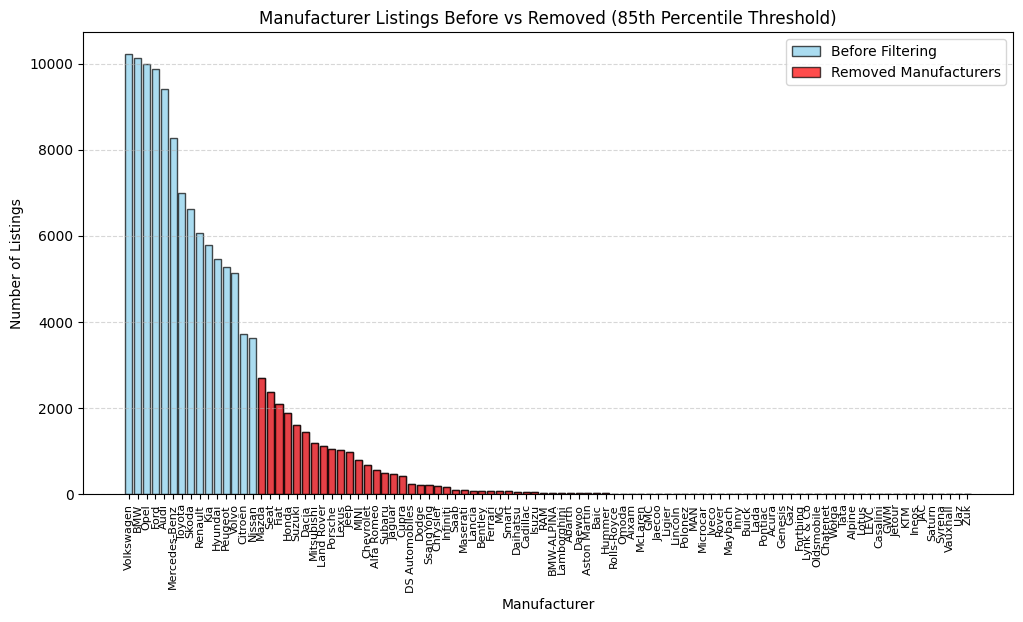

In [ ]:
# threshold for outliers based on the 85th percentile
outlier_threshold = int(np.percentile(manufacturer_counts, 85))

outlier_manufacturers = manufacturer_counts[manufacturer_counts < outlier_threshold].index

filtered_data = data[~data['make'].isin(outlier_manufacturers)].copy()

plt.figure(figsize=(12, 6))

plt.bar(manufacturer_counts.index, manufacturer_counts.values, color='skyblue', edgecolor='black', alpha=0.7, label="Before Filtering")

removed_counts = manufacturer_counts[manufacturer_counts < outlier_threshold]
plt.bar(removed_counts.index, removed_counts.values, color='red', edgecolor='black', alpha=0.7, label="Removed Manufacturers")

plt.xlabel('Manufacturer')
plt.ylabel('Number of Listings')
plt.title('Manufacturer Listings Before vs Removed (85th Percentile Threshold)')
plt.xticks(rotation=90, fontsize=8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

- Manufacturers with **very few listings are removed, reducing noise in the data**.
- Enough **diversity is retained**.

## Year preparation & cleanup

- **Older cars (pre-1995)** are considered **outliers** and have been **filtered out** to focus on modern trends.  

### Car Year Distribution Analysis

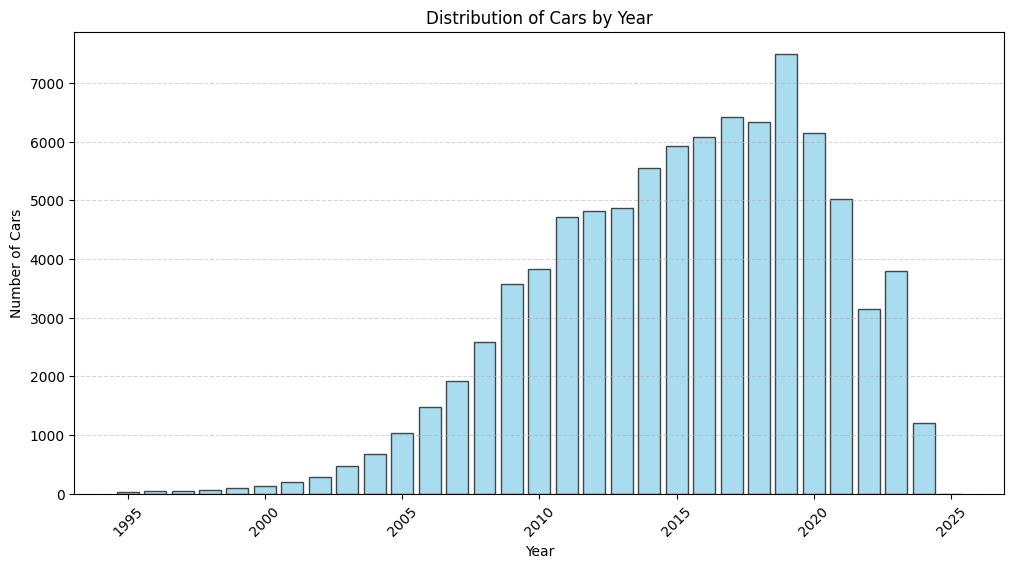

In [59]:
year_counts = filtered_data['year'].value_counts().sort_index()

# bar chart for year distribution
plt.figure(figsize=(12, 6))
plt.bar(year_counts.index, year_counts.values, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Number of Cars')
plt.title('Distribution of Cars by Year')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()


**Distribution of Cars by Year**
The histogram shows the **distribution of car years**, revealing key trends:  
- Most cars are from **2000 and newer**, with a **significant increase after 2010**.  
- There are very few cars before **1980**, meaning these might be rare or vintage models.  
- The peak is around **2020**, suggesting a high number of **recently listed cars**.  

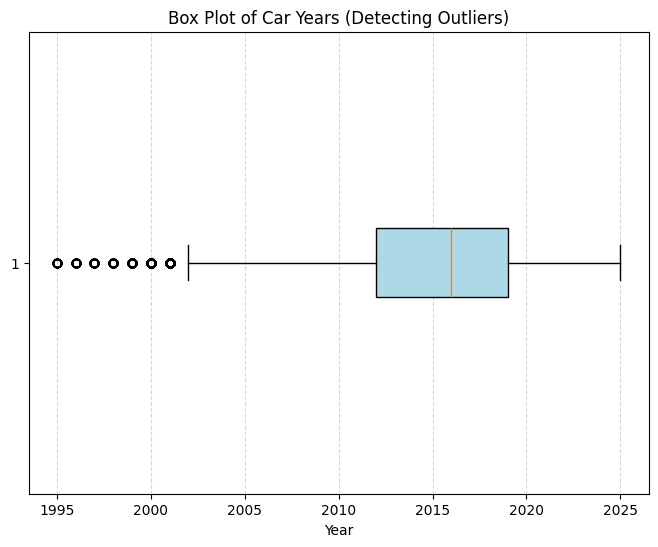

In [60]:
plt.figure(figsize=(8, 6))
plt.boxplot(filtered_data['year'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))

plt.xlabel('Year')
plt.title('Box Plot of Car Years (Detecting Outliers)')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()


**Box Plot of Car Years (Detecting Outliers)**
The **box plot** helps identify outliers and the general distribution:  
- The **majority of cars** fall within the **interquartile range (IQR)** from **2000 onward**.  
- **Older cars (pre-1980)** appear as **outliers**, suggesting they are much less common.  
- The **whiskers extend close to 2023**, indicate newer models are represented.  
- The **presence of many outliers** before 1980 reinforces that these are **rare entries**.  


**Conclusion**
- The dataset is **skewed toward modern cars**, with **older cars appearing as clear outliers**.
- This suggests that the dataset might be **useful for modern car trend analysis**, but **not well-suited for analyzing classic car trends** due to the small number of older cars and this is exactly what we are aiming for.

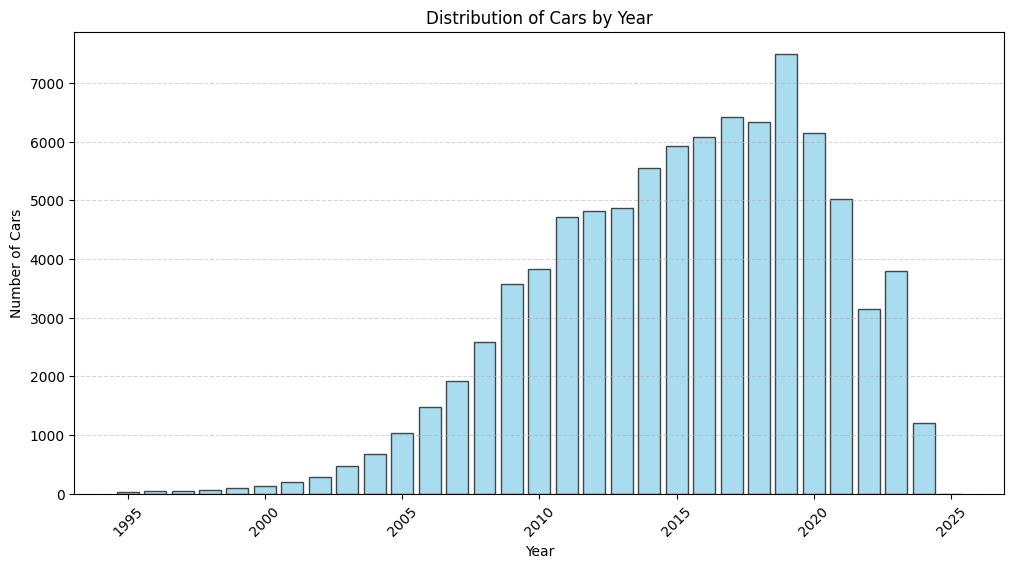

In [61]:
filtered_data = filtered_data[filtered_data['year'] >= 1995]

year_counts = filtered_data['year'].value_counts().sort_index()
plt.figure(figsize=(12, 6))
plt.bar(year_counts.index, year_counts.values, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Year')
plt.ylabel('Number of Cars')
plt.title('Distribution of Cars by Year')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)


Filtering out older cars is helping here in **reducing noise** and **improving model accuracy for price prediction**.

## Mileage preparation & cleanup

- Using **IQR for outlier removal.**
- Filtering out **cars under 500 KMs mileage (essentially removing new cars and wrong mileage)**.

In [8]:
print("Before float parsing:")
print(filtered_data['mileage'].head(10))
filtered_data['mileage'] = filtered_data['mileage'].str.replace('KM', '', regex=False).str.replace(' ', '').str.replace('km', '').astype(float)
print("After:")
print(filtered_data['mileage'].head(10))

Before float parsing:
0     73 000 km
1    180 000 km
2    218 000 km
3    250 500 km
4    275 000 km
5    112 000 km
6    170 232 km
7     95 592 km
8    224 523 km
9    293 000 km
Name: mileage, dtype: object
After:
0     73000.0
1    180000.0
2    218000.0
3    250500.0
4    275000.0
5    112000.0
6    170232.0
7     95592.0
8    224523.0
9    293000.0
Name: mileage, dtype: float64


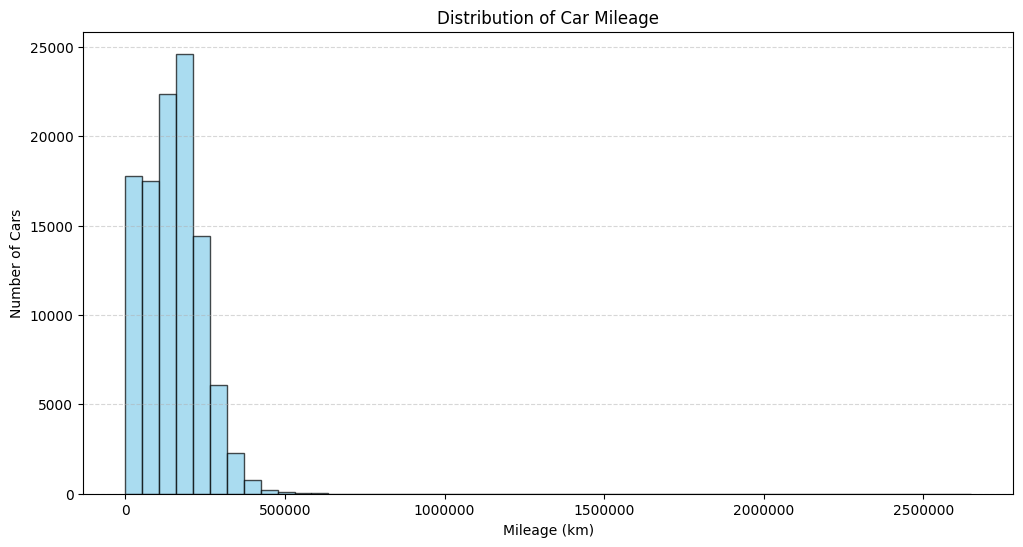

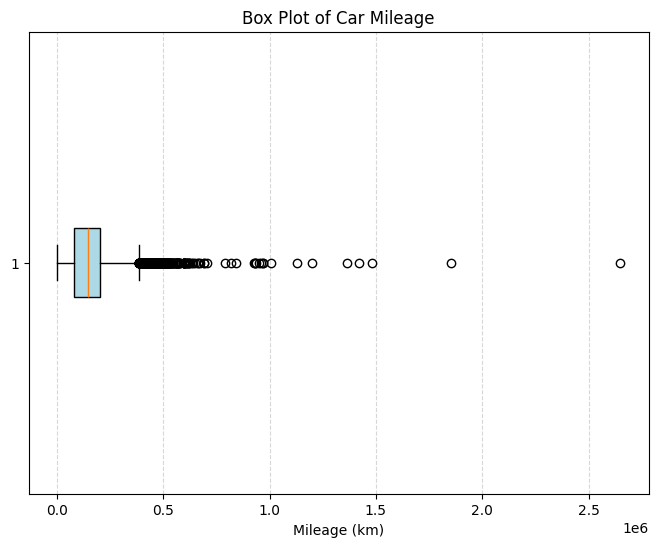

In [9]:
plt.figure(figsize=(12, 6))
plt.hist(filtered_data['mileage'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Mileage (km)')
plt.ylabel('Number of Cars')
plt.title('Distribution of Car Mileage')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.ticklabel_format(style='plain', axis='x') 
plt.show()


plt.figure(figsize=(8, 6))
plt.boxplot(filtered_data['mileage'], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))

plt.xlabel('Mileage (km)')
plt.title('Box Plot of Car Mileage')
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.show()



New dataset size after removing unrealistic low mileage: 104928 rows


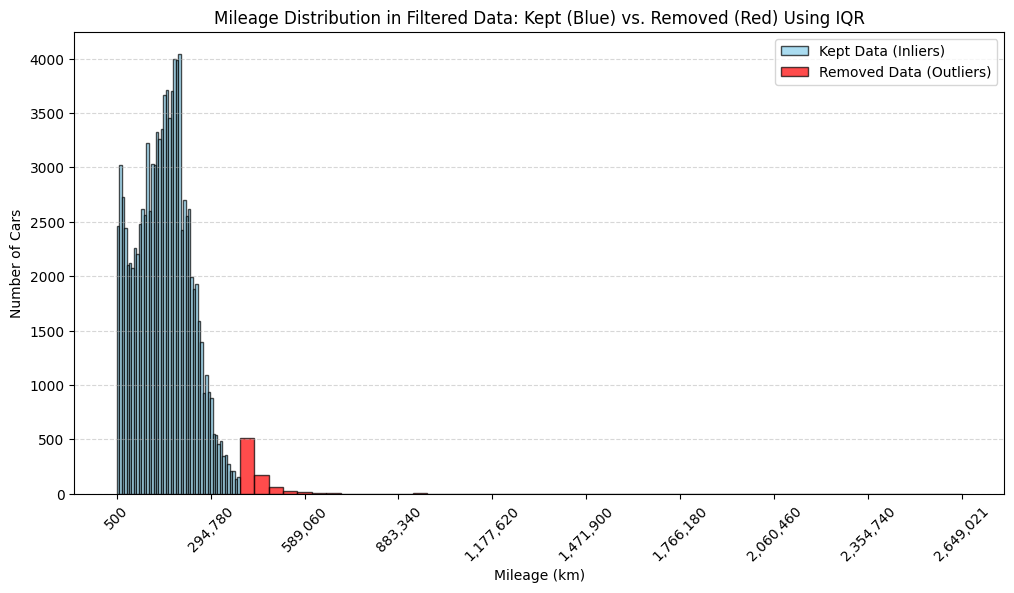

New dataset size after removing IQR outliers: 104096 rows


In [10]:

filtered_data = filtered_data[filtered_data['mileage'] >= 500]

print(f"New dataset size after removing unrealistic low mileage (lower than 500 km): {len(filtered_data)} rows")


#  IQR for mileage on filtered data
Q1 = np.percentile(filtered_data['mileage'], 25)
Q3 = np.percentile(filtered_data['mileage'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_inliers = filtered_data[(filtered_data['mileage'] >= lower_bound) & (filtered_data['mileage'] <= upper_bound)]
filtered_outliers = filtered_data[(filtered_data['mileage'] < lower_bound) | (filtered_data['mileage'] > upper_bound)]

#  histogram for filtered data
plt.figure(figsize=(12, 6))
plt.hist(filtered_inliers['mileage'], bins=50, color='skyblue', edgecolor='black', alpha=0.7, label="Kept Data (Inliers)")
plt.hist(filtered_outliers['mileage'], bins=50, color='red', edgecolor='black', alpha=0.7, label="Removed Data (Outliers)")

plt.xlabel('Mileage (km)')
plt.ylabel('Number of Cars')
plt.title('Mileage Distribution in Filtered Data: Kept (Blue) vs. Removed (Red) Using IQR')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ticklabel_format(style='plain', axis='x') 



plt.show()

# Apply IQR filtering to remove outliers from filtered_data
filtered_data = filtered_data[(filtered_data['mileage'] >= lower_bound) & (filtered_data['mileage'] <= upper_bound)]

print(f"New dataset size after removing IQR outliers: {len(filtered_data)} rows")

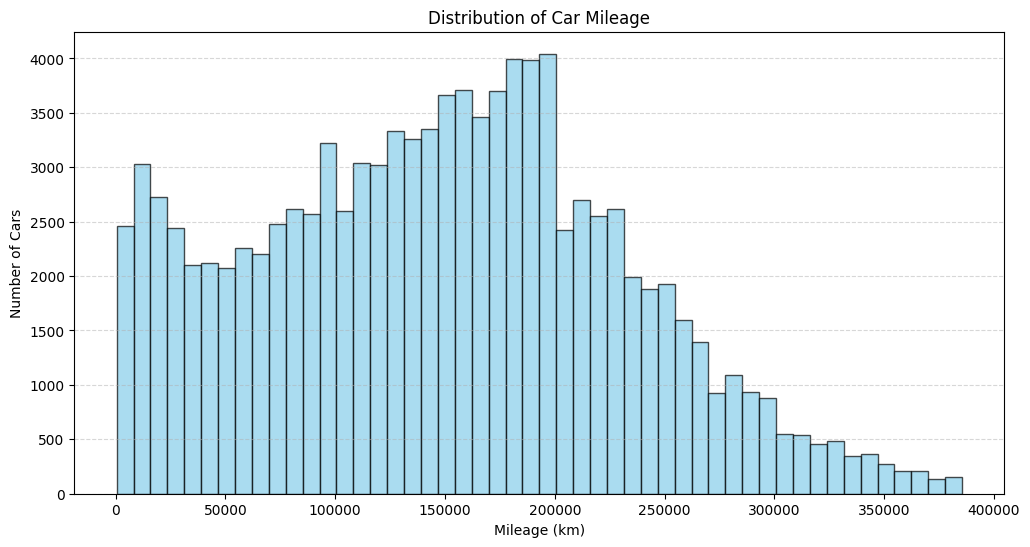

In [11]:

plt.figure(figsize=(12, 6))
plt.hist(filtered_data['mileage'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Mileage (km)')
plt.ylabel('Number of Cars')
plt.title('Distribution of Car Mileage')
plt.grid(axis='y', linestyle='--', alpha=0.5)

median_mileage = np.median(filtered_data['mileage'])


There appear to be two peaks:
- One around 50,000 - 100,000 km (newer used cars).
- Another around 150,000 - 200,000 km (older cars still in use).
- This suggests two main groups of sellers: those with relatively new cars and those with well-driven but still usable cars.


- Cars with 200,000+ km start decreasing, which is expected as high-mileage cars become less desirable and often break/get scrapped.
- Many listings still exist for 300,000+ km, meaning a part of the market consists of very high-mileage cars.
- Almost no cars beyond 400,000 km, indicating many cars don’t even reach this mileage before being scrapped.

There are spikes at certain mileage points (e.g. 100 k, 200k, 300k) might indicate rounded values in listings by the seller or "krecenie licznika".


## Gearbox preparation & cleanup

The dataset originally contained **Polish gearbox types names**, which were mapped to standardized English names for consistency. 

Top 10 common gearbox types before mapping:
gearbox
Manualna        56226
Automatyczna    47870
Name: count, dtype: int64
Top 10 common gearbox types after mapping:
gearbox
Manual       56226
Automatic    47870
Name: count, dtype: int64


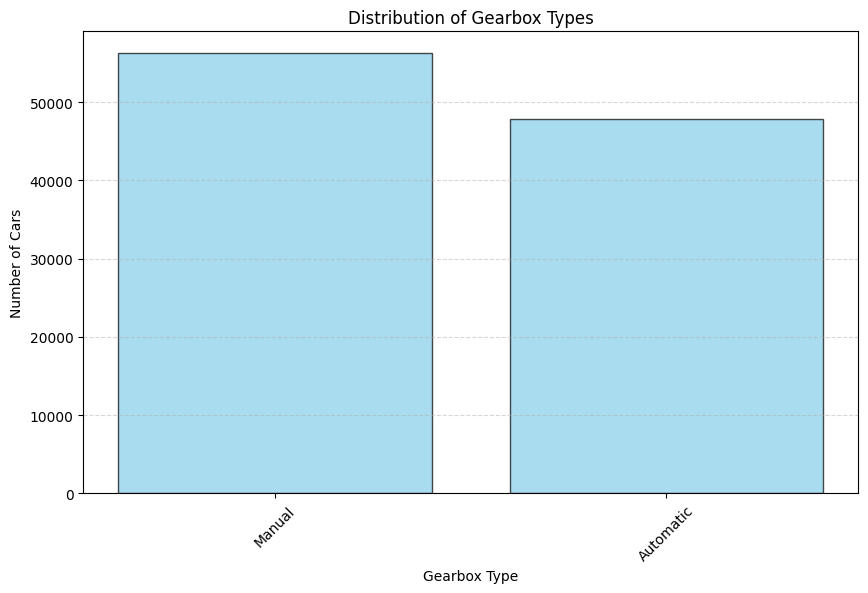

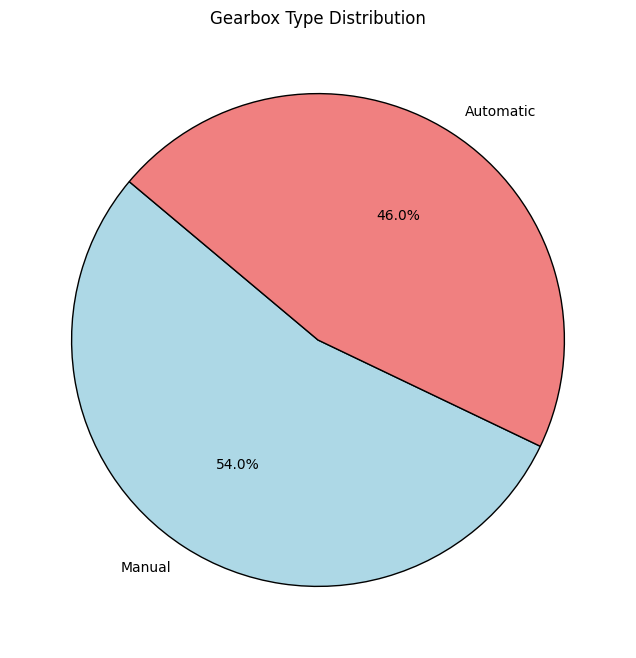

In [12]:
print("Top 10 common gearbox types before mapping:")
print(filtered_data['gearbox'].value_counts().head(10))
gearbox_mapping = {
    "Manualna": "Manual",
    "Automatyczna": "Automatic",
}
filtered_data["gearbox"] = filtered_data["gearbox"].map(gearbox_mapping).fillna(filtered_data["gearbox"])

print("Top 10 common gearbox types after mapping:")
print(filtered_data['gearbox'].value_counts().head(10))

gearbox_counts = filtered_data['gearbox'].value_counts()

# Bar Chart for Gearbox Distribution
plt.figure(figsize=(10, 6))
plt.bar(gearbox_counts.index, gearbox_counts.values, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Gearbox Type')
plt.ylabel('Number of Cars')
plt.title('Distribution of Gearbox Types')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# Pie Chart for Gearbox Distribution
plt.figure(figsize=(8, 8))
plt.pie(gearbox_counts, labels=gearbox_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightblue', 'lightcoral'], wedgeprops={'edgecolor': 'black'})
plt.title('Gearbox Type Distribution')
plt.show()

- The dataset contains two main gearbox types: Manual and Automatic.
- Manual transmissions are slightly more common than automatic ones.
- The difference is small, meaning the dataset has a balance of both types.

## Fuel Type preparation & cleanup

The dataset originally contained **Polish fuel type names**, which were mapped to standardized English names for consistency.  

Polish fuel names:
['Benzyna' 'Diesel' 'Hybryda' 'Benzyna+LPG' 'Hybryda Plug-in'
 'Benzyna+CNG' 'Wodór']
New fuel names:
['Petrol' 'Diesel' 'Hybrid' 'Petrol+LPG' 'Plug-in Hybrid' 'Petrol+CNG'
 'Hydrogen']


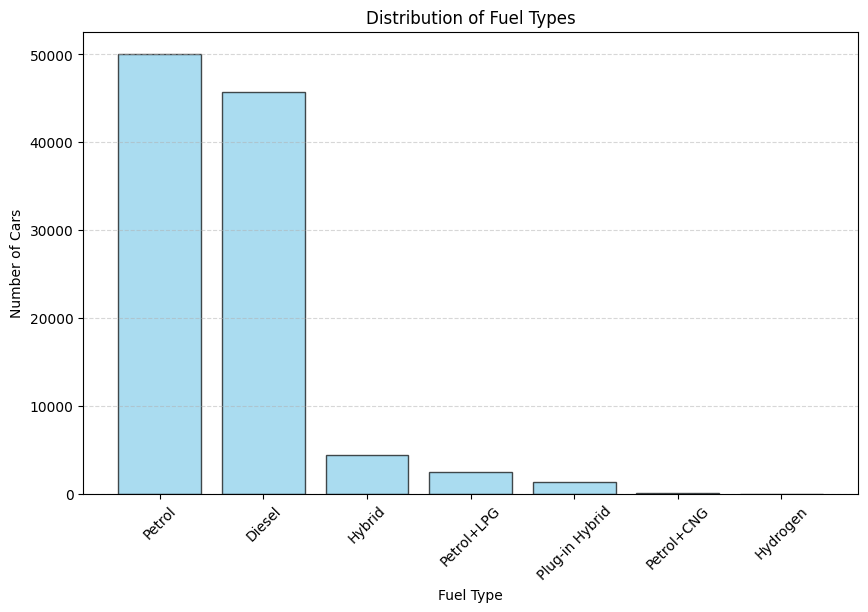

In [13]:
print("Polish fuel names:")
print(filtered_data["fuel_type"].unique())

fuel_type_mapping = {
    "Benzyna": "Petrol",
    "Diesel": "Diesel",
    "Hybryda": "Hybrid",
    "Benzyna+LPG": "Petrol+LPG",
    "Hybryda Plug-in": "Plug-in Hybrid",
    "Benzyna+CNG": "Petrol+CNG",
    "Wodór": "Hydrogen"
}

filtered_data["fuel_type"] = filtered_data["fuel_type"].map(fuel_type_mapping)

print("New fuel names:")
print(filtered_data["fuel_type"].unique())

fuel_counts = filtered_data['fuel_type'].value_counts()

#  bar chart for fuel type distribution
plt.figure(figsize=(10, 6))
plt.bar(fuel_counts.index, fuel_counts.values, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Fuel Type')
plt.ylabel('Number of Cars')
plt.title('Distribution of Fuel Types')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.show()

- **Petrol and Diesel dominate the dataset**, making up the vast majority of cars.  
- **Hybrid and Petrol+LPG cars are significantly less common**, 
- **Plug-in Hybrid, Petrol+CNG, and Hydrogen have very low counts**

**What does it mean?**
- Any **predictive model** trained on this dataset will be **heavily biased** toward Petrol and Diesel cars.  
- It is a good idea to **remove the rarest fuel types** (`Petrol+CNG` and `Hydrogen`) to reduce noise. 

In [ ]:
print("Removing two of the most rare types of fuel.")
filtered_data = filtered_data[~filtered_data['fuel_type'].isin(['Petrol+CNG', 'Hydrogen'])]

Removing two the most rare types of fuel.


## Colors preparation & cleanup

Unique Colors in Dataset:
Czarny
Czerwony
Biały
Srebrny
Brązowy
Inny kolor
Fioletowy
Granatowy
Szary
Bordowy
Niebieski
Błękitny
Pomarańczowy
Zielony
Złoty
Beżowy
Żółty


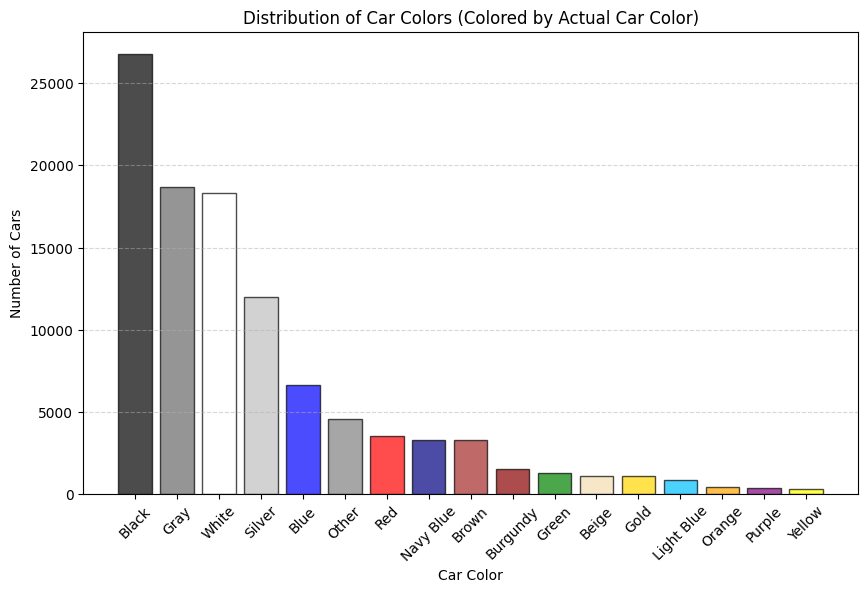

In [ ]:

unique_colors = filtered_data["color"].unique()
print("Unique Colors in Dataset:")
for color in unique_colors:
    print(color)

color_mapping = {
    "Czarny": "Black",
    "Czerwony": "Red",
    "Srebrny": "Silver",
    "Biały": "White",
    "Inny kolor": "Other",
    "Fioletowy": "Purple",
    "Granatowy": "Navy Blue",
    "Niebieski": "Blue",
    "Brązowy": "Brown",
    "Błękitny": "Light Blue",
    "Szary": "Gray",
    "Pomarańczowy": "Orange",
    "Zielony": "Green",
    "Bordowy": "Burgundy",
    "Złoty": "Gold",
    "Beżowy": "Beige",
    "Żółty": "Yellow"
}

filtered_data["color"] = filtered_data["color"].map(color_mapping).fillna(filtered_data["color"])

color_mapping_plt= {
    "Black": "black",
    "Red": "red",
    "Silver": "silver",
    "White": "white",
    "Other": "gray",
    "Purple": "purple",
    "Navy Blue": "navy",
    "Blue": "blue",
    "Brown": "brown",
    "Light Blue": "deepskyblue",
    "Gray": "dimgray",
    "Orange": "orange",
    "Green": "green",
    "Burgundy": "darkred",
    "Gold": "gold",
    "Beige": "wheat",
    "Yellow": "yellow"
}

if 'color' in filtered_data.columns:
    color_counts = filtered_data['color'].value_counts()

    color_labels = [color_mapping_plt.get(color, "gray") for color in color_counts.index]

    bar_colors = [color_mapping_plt.get(color, "gray") for color in color_counts.index]

    # bar chart for color distribution
    plt.figure(figsize=(10, 6))
    plt.bar(color_counts.index, color_counts.values, color=bar_colors, edgecolor='black', alpha=0.7)

    plt.xlabel('Car Color')
    plt.ylabel('Number of Cars')
    plt.title('Distribution of Car Colors (Colored by Actual Car Color)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

    plt.show()
else:
    print("Column 'color' not found in the dataset. Please check the column names.")

- The **most common car colors** are **Black, Gray, White, and Silver**
- **Blue and Red** are moderately popular but significantly less frequent than neutral colors.  
- **Less common colors** include **Burgundy, Gold, Yellow, and Purple**, indicating they are less likely to be found on otomoto.

- Since neutral colors dominate, we may think **pricing models may reflect a bias** toward these colors, but this is highly unlikely, as this is a result of a neutral color being popular among manufacturers rather than actual preferences.

## Number of seats and number of doors preparation & cleanup

 **Filling Missing Values**: \
 **NaNs replaced using a hierarchical median approach**:
  1. `make × model × version`
  2. `make × model`
  3. `make`


In [16]:
missing_before = filtered_data[['door_count', 'nr_seats']].isnull().sum()
print("Missing values before filling:")
print(missing_before)

filtered_data[['door_count', 'nr_seats']] = filtered_data[['door_count', 'nr_seats']].astype('float64')

median_version = filtered_data.groupby(['make', 'model', 'version'])[['door_count', 'nr_seats']].median()

median_model = filtered_data.groupby(['make', 'model'])[['door_count', 'nr_seats']].median()

median_make = filtered_data.groupby(['make'])[['door_count', 'nr_seats']].median()

filtered_data = filtered_data.merge(median_version, on=['make', 'model', 'version'], how='left', suffixes=('', '_median_version'))
filtered_data = filtered_data.merge(median_model, on=['make', 'model'], how='left', suffixes=('', '_median_model'))
filtered_data = filtered_data.merge(median_make, on=['make'], how='left', suffixes=('', '_median_make'))

filtered_data['door_count'] = filtered_data['door_count'].fillna(filtered_data['door_count_median_version'])
filtered_data['door_count'] = filtered_data['door_count'].fillna(filtered_data['door_count_median_model'])
filtered_data['door_count'] = filtered_data['door_count'].fillna(filtered_data['door_count_median_make'])

filtered_data['nr_seats'] = filtered_data['nr_seats'].fillna(filtered_data['nr_seats_median_version'])
filtered_data['nr_seats'] = filtered_data['nr_seats'].fillna(filtered_data['nr_seats_median_model'])
filtered_data['nr_seats'] = filtered_data['nr_seats'].fillna(filtered_data['nr_seats_median_make'])

filtered_data.drop(columns=['door_count_median_version', 'door_count_median_model', 'door_count_median_make',
                            'nr_seats_median_version', 'nr_seats_median_model', 'nr_seats_median_make'], inplace=True)

missing_after = filtered_data[['door_count', 'nr_seats']].isnull().sum()
print("\nMissing values after filling:")
print(missing_after)

Missing values before filling:
door_count     145
nr_seats      3865
dtype: int64

Missing values after filling:
door_count    0
nr_seats      0
dtype: int64


## Engine Capacity preparation & cleanup

- Converted engine capacity values from string (e.g., "999 cm³") to **numerical format**.
- **Used Interquartile Range (IQR)** to detect outliers.

Before cleaning:
0    1 999 cm3
1    1 498 cm3
2    1 199 cm3
3    1 595 cm3
4    4 134 cm3
5    1 598 cm3
6    1 560 cm3
7      999 cm3
8    2 967 cm3
9    2 979 cm3
Name: engine_capacity, dtype: object

After cleaning:
0    1999.0
1    1498.0
2    1199.0
3    1595.0
4    4134.0
5    1598.0
6    1560.0
7     999.0
8    2967.0
9    2979.0
Name: engine_capacity, dtype: float64


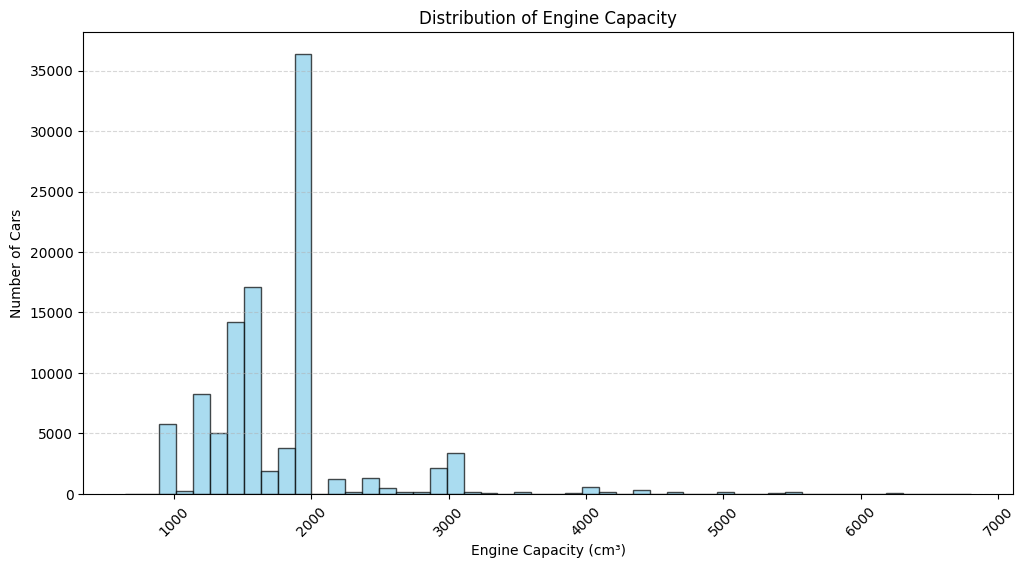

Median Engine Capacity: 1686.00 cm³


In [17]:
print("Before cleaning:")
print(filtered_data['engine_capacity'].head(10))

# Remove 'cm3' and spaces, -> float
filtered_data['engine_capacity'] = (
    filtered_data['engine_capacity']
    .astype(str)
    .str.replace('cm3', '', regex=False) 
    .str.replace(' ', '', regex=False)  
    .astype(float)  
)

print("\nAfter cleaning:")
print(filtered_data['engine_capacity'].head(10))

# histogram for engine capacity distribution
plt.figure(figsize=(12, 6))
plt.hist(filtered_data['engine_capacity'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Engine Capacity (cm³)')
plt.ylabel('Number of Cars')
plt.title('Distribution of Engine Capacity')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)

plt.show()

median_engine_capacity = filtered_data['engine_capacity'].median()
print(f"Median Engine Capacity: {median_engine_capacity:.2f} cm³")


- Most common engine sizes fall **within a reasonable range (1,000 cm³ - 3,000 cm³).**
- Right-skewed distribution – **Some larger engines exist, but they are less common**.
- **Some possible outliers at extremely high engine capacities** (exceeding 3,000 cm³).

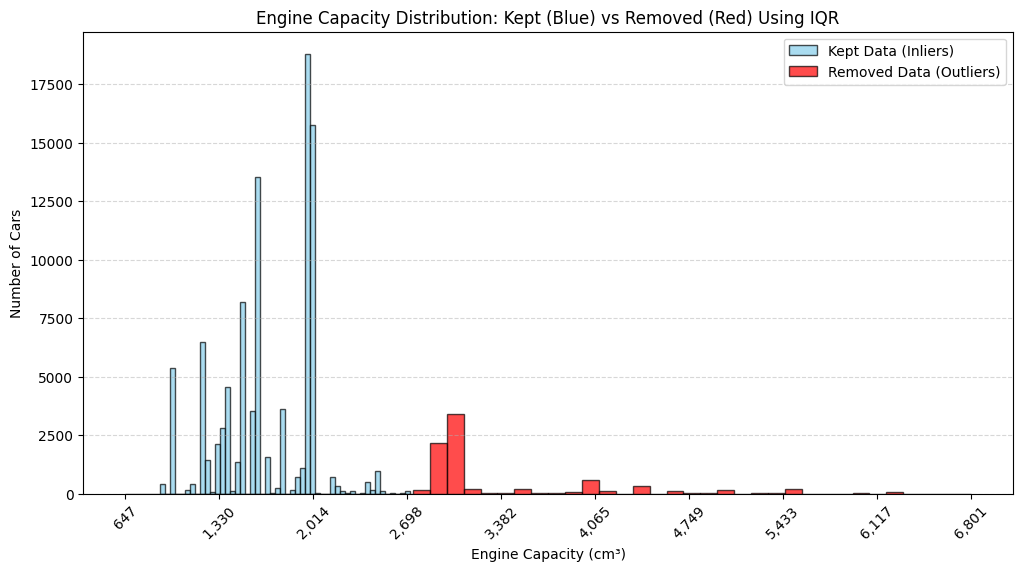

In [18]:
# IQR for engine capacity
Q1 = np.percentile(filtered_data['engine_capacity'], 25)
Q3 = np.percentile(filtered_data['engine_capacity'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# inliers and outliers
inliers = filtered_data[(filtered_data['engine_capacity'] >= lower_bound) & (filtered_data['engine_capacity'] <= upper_bound)]
outliers = filtered_data[(filtered_data['engine_capacity'] < lower_bound) | (filtered_data['engine_capacity'] > upper_bound)]

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(inliers['engine_capacity'], bins=50, color='skyblue', edgecolor='black', alpha=0.7, label="Kept Data (Inliers)")
plt.hist(outliers['engine_capacity'], bins=50, color='red', edgecolor='black', alpha=0.7, label="Removed Data (Outliers)")

plt.xlabel('Engine Capacity (cm³)')
plt.ylabel('Number of Cars')
plt.title('Engine Capacity Distribution: Kept (Blue) vs Removed (Red) Using IQR')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)


plt.show()

**Most data is concentrated in a reasonable range, with a few extreme outliers removed.**

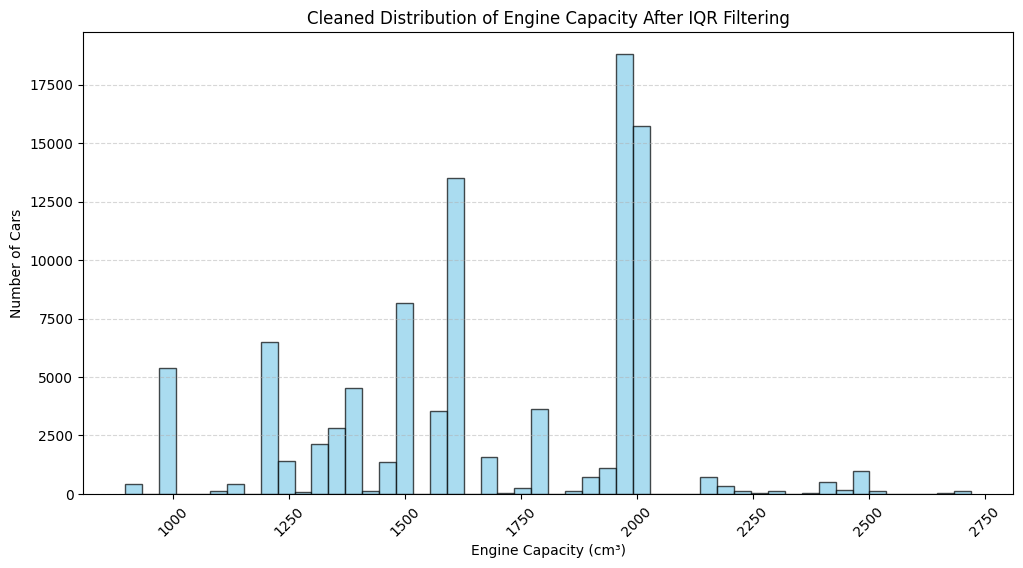

In [19]:
filtered_data = filtered_data[(filtered_data['engine_capacity'] >= lower_bound) & (filtered_data['engine_capacity'] <= upper_bound)]

# Plot histogram for cleaned engine capacity distribution
plt.figure(figsize=(12, 6))
plt.hist(filtered_data['engine_capacity'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Engine Capacity (cm³)')
plt.ylabel('Number of Cars')
plt.title('Cleaned Distribution of Engine Capacity After IQR Filtering')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.xticks(rotation=45)

plt.show()


- The **right-skewed tail has been removed**, keeping only **reasonable engine sizes** due to the **IQR filtering**.
- The most common engine capacities are around **1000 cm³, 1250 cm³, 1400 cm³, 1600 cm³, and 2000 cm³.**
- These **peaks suggest popular engine sizes in the market**, probably reflecting common vehicle engine sizes and car categories (e.g., small city cars, mid-size cars).

## Engine_power preparation & cleanup

- Converted engine power values from string (e.g., "242 KM") to **numerical format**.
- **Used Interquartile Range (IQR) to detect outliers.**

In [20]:
print("Before cleaning:")
print(filtered_data['engine_power'].head(10))

# Remove 'KM', 'km', and spaces, then convert to float
filtered_data['engine_power'] = (
    filtered_data['engine_power']
    .astype(str) 
    .str.replace('KM', '', regex=False) 
    .str.replace('km', '', regex=False)  
    .str.replace(' ', '', regex=False)  
    .astype(float)  
)

print("\nAfter cleaning:")
print(filtered_data['engine_power'].head(10))


Before cleaning:
0     242 KM
1      75 KM
2      82 KM
3     102 KM
5     130 KM
6     115 KM
7      95 KM
10     95 KM
11    150 KM
12    110 KM
Name: engine_power, dtype: object

After cleaning:
0     242.0
1      75.0
2      82.0
3     102.0
5     130.0
6     115.0
7      95.0
10     95.0
11    150.0
12    110.0
Name: engine_power, dtype: float64


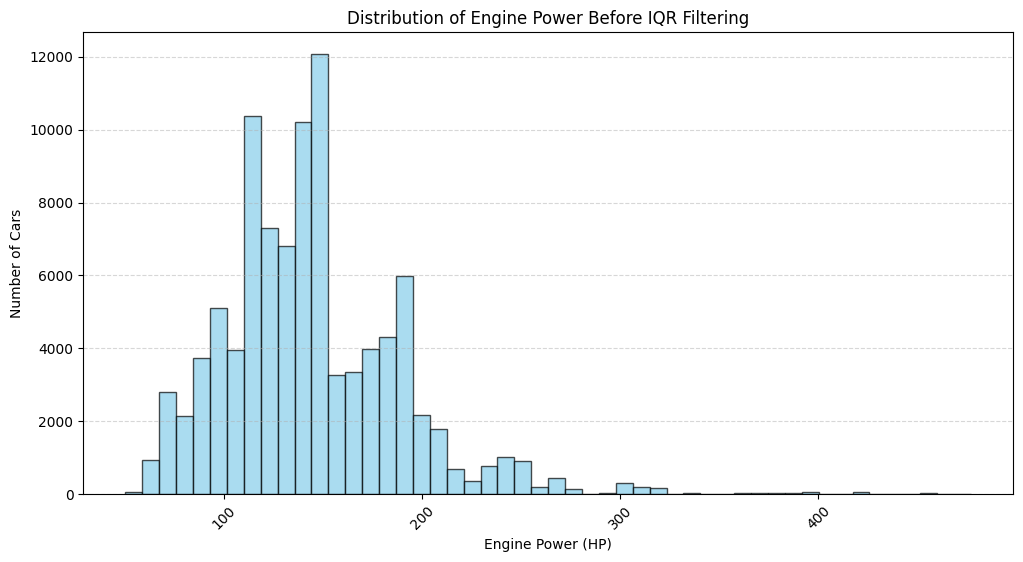

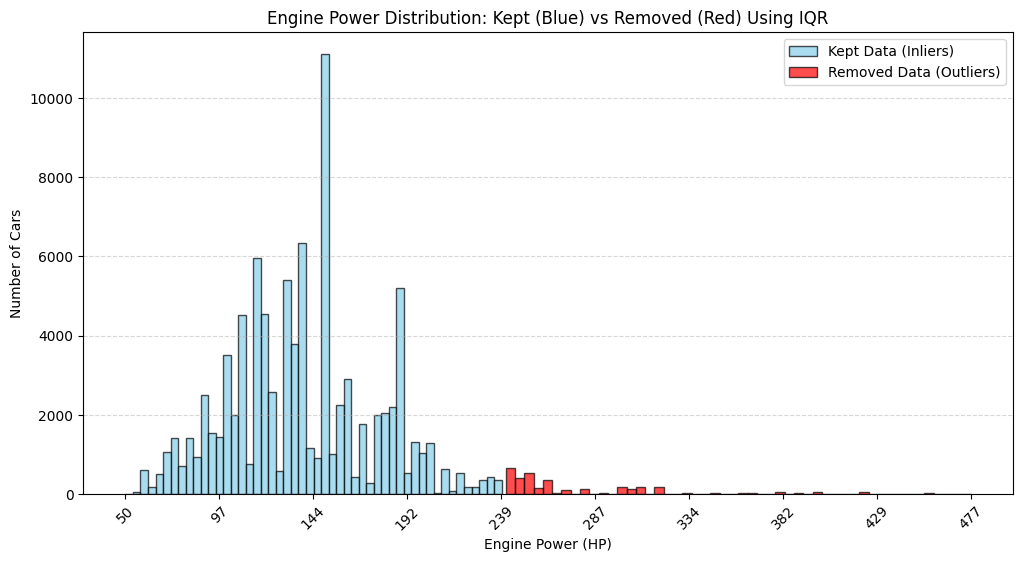

In [21]:
# Compute IQR for engine power
Q1 = np.percentile(filtered_data['engine_power'], 25)
Q3 = np.percentile(filtered_data['engine_power'], 75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Separate inliers and outliers
inliers = filtered_data[(filtered_data['engine_power'] >= lower_bound) & (filtered_data['engine_power'] <= upper_bound)]
outliers = filtered_data[(filtered_data['engine_power'] < lower_bound) | (filtered_data['engine_power'] > upper_bound)]

#  histogram before IQR filtering
plt.figure(figsize=(12, 6))
plt.hist(filtered_data['engine_power'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Engine Power (HP)')
plt.ylabel('Number of Cars')
plt.title('Distribution of Engine Power Before IQR Filtering')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.show()

#  histogram after IQR filtering with inliers (blue) and outliers (red)
plt.figure(figsize=(12, 6))
plt.hist(inliers['engine_power'], bins=50, color='skyblue', edgecolor='black', alpha=0.7, label="Kept Data (Inliers)")
plt.hist(outliers['engine_power'], bins=50, color='red', edgecolor='black', alpha=0.7, label="Removed Data (Outliers)")

plt.xlabel('Engine Power (HP)')
plt.ylabel('Number of Cars')
plt.title('Engine Power Distribution: Kept (Blue) vs Removed (Red) Using IQR')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ticklabel_format(style='plain', axis='x') 
plt.show()

**Engine Power Distribution before removal**
- **Right-skewed distribution** - majority of cars have engines between 80 and 200 HP, with a significant peak around 140 HP.
- Some extreme values (above 400 HP) exist but are rare.
- The **most common appear in increments, likely corresponding to standard manufacturer configurations** (e.g., 90 HP, 120 HP, 150 HP).

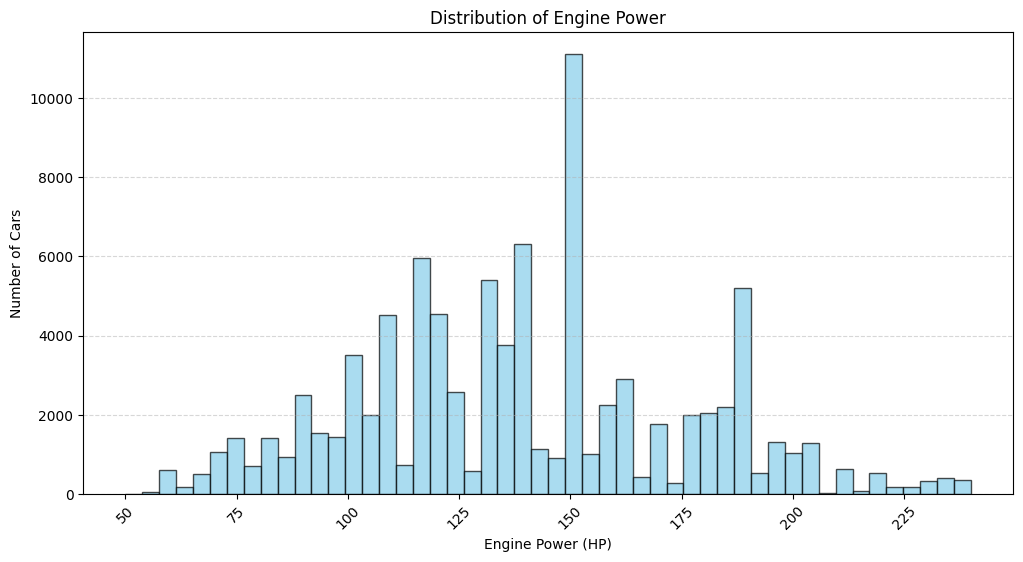

In [22]:
filtered_data = filtered_data[(filtered_data['engine_power'] >= lower_bound) & (filtered_data['engine_power'] <= upper_bound)]

# histogram for engine power distribution
plt.figure(figsize=(12, 6))
plt.hist(filtered_data['engine_power'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)

plt.xlabel('Engine Power (HP)')
plt.ylabel('Number of Cars')
plt.title('Distribution of Engine Power')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.xticks(rotation=45)

plt.show()

**Engine Power Distribution after removal**
- Some high-powered cars (200+ HP) remain, **indicating that we successfully removed extreme outliers without affecting valid listings**.
- The majority of cars fall between 75 HP and 200 HP, which **aligns with everyday cars**.
- The peak is at around 150 HP.
- **More structured distribution** of engine power.

## Price preparation & cleanup

- To ensure a more accurate price distribution, we apply an **Interquartile Range (IQR) filter** to remove extreme outliers.  

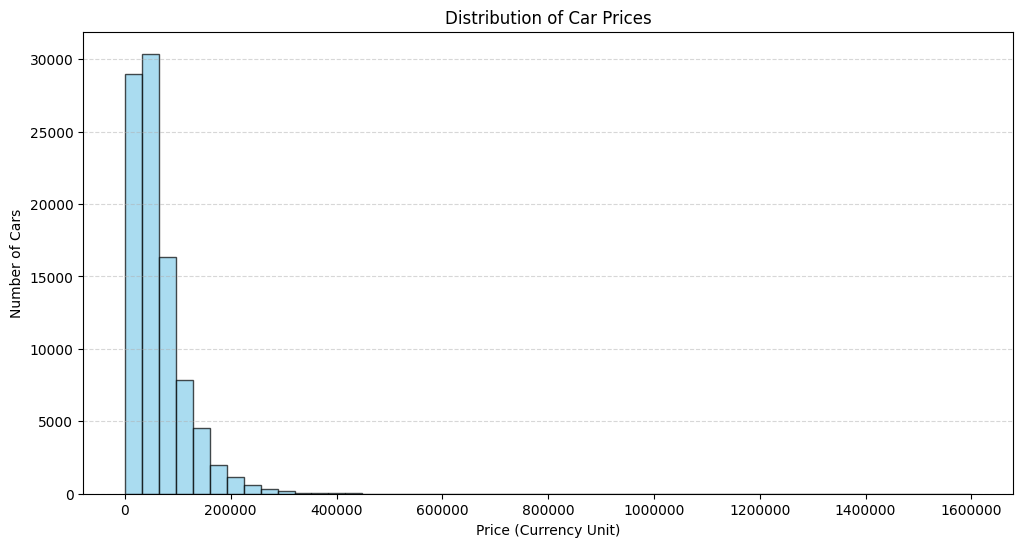

In [23]:
filtered_data['price'] = (
    filtered_data['price']
    .astype(str)  
    .str.replace('PLN', '', regex=False)  
    .str.replace(' ', '', regex=False)  
    .str.replace(',', '.', regex=False)  
    .astype(float)  
)
# Plot histogram for price distribution
plt.figure(figsize=(12, 6))
plt.hist(filtered_data['price'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)


plt.xlabel('Price (Currency Unit)')
plt.ylabel('Number of Cars')
plt.title('Distribution of Car Prices')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.ticklabel_format(style='plain', axis='x') 

plt.show()

**Price Distribution Insights**  

- **Most cars are clustered in the lower price range**, with a sharp decline as prices increase.  
- The dataset **contains a high number of budget-friendly used cars**, with fewer premium or luxury models, which aligns with the typical listings on Otomoto.  
- A long right tail suggests the presence of extremely high-priced cars, likely luxury or sports models.  

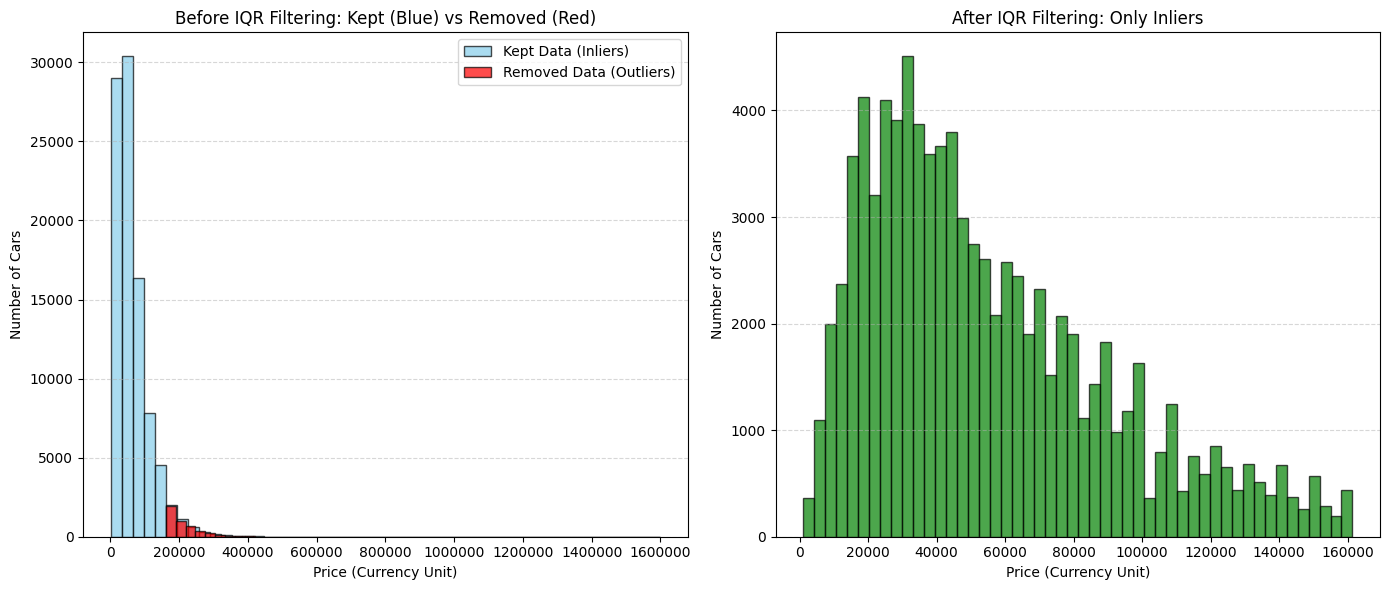

In [24]:
Q1, Q3 = np.percentile(filtered_data['price'], [25, 75])
IQR = Q3 - Q1
lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

filtered_data_1 = filtered_data[(filtered_data['price'] >= lower_bound) & (filtered_data['price'] <= upper_bound)]
outliers_1 = filtered_data[(filtered_data['price'] < lower_bound) | (filtered_data['price'] > upper_bound)]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Before filtering: inliers (blue) and outliers (red)
ax[0].hist(filtered_data['price'], bins=50, color='skyblue', edgecolor='black', alpha=0.7, label="Kept Data (Inliers)")
ax[0].hist(outliers_1['price'], bins=50, color='red', edgecolor='black', alpha=0.7, label="Removed Data (Outliers)")
ax[0].set_xlabel('Price (Currency Unit)')
ax[0].set_ylabel('Number of Cars')
ax[0].set_title('Before IQR Filtering: Kept (Blue) vs Removed (Red)')
ax[0].grid(axis='y', linestyle='--', alpha=0.5)
ax[0].ticklabel_format(style='plain', axis='x')
ax[0].legend()

# After filtering: Only inliers
ax[1].hist(filtered_data_1['price'], bins=50, color='green', edgecolor='black', alpha=0.7)
ax[1].set_xlabel('Price (Currency Unit)')
ax[1].set_ylabel('Number of Cars')
ax[1].set_title('After IQR Filtering: Only Inliers')
ax[1].grid(axis='y', linestyle='--', alpha=0.5)
ax[1].ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()

filtered_data = filtered_data_1

**Price Distribution After Filtering**  

- The **natural shape of the distribution is preserved** without excessive data removal.  
- **Extreme high-price cars (luxury/exotics) were filtered out**, making the **range more realistic** for typical buyers especially in Poland.  
- Some **higher-priced cars remain**, ensuring that the **dataset still reflects a diverse market**.  


# Analysis

### Summary after cleanup and preparation

               price    door_count      nr_seats          year  \
count   88052.000000  88052.000000  88052.000000  88052.000000   
mean    54942.669141      4.831588      5.091713   2015.213681   
std     35499.388388      0.503879      0.648667      5.036757   
min       999.000000      2.000000      1.000000   1995.000000   
25%     27500.000000      5.000000      5.000000   2012.000000   
50%     45900.000000      5.000000      5.000000   2016.000000   
75%     75000.000000      5.000000      5.000000   2019.000000   
max    161400.000000      6.000000      9.000000   2025.000000   

       engine_capacity  engine_power        mileage  
count     88052.000000  88052.000000   88052.000000  
mean       1648.499796    136.389179  155178.595841  
std         339.096830     35.283015   78374.506983  
min         898.000000     50.000000     500.000000  
25%        1397.000000    110.000000   98598.000000  
50%        1598.000000    136.000000  157203.000000  
75%        1968.000000    1

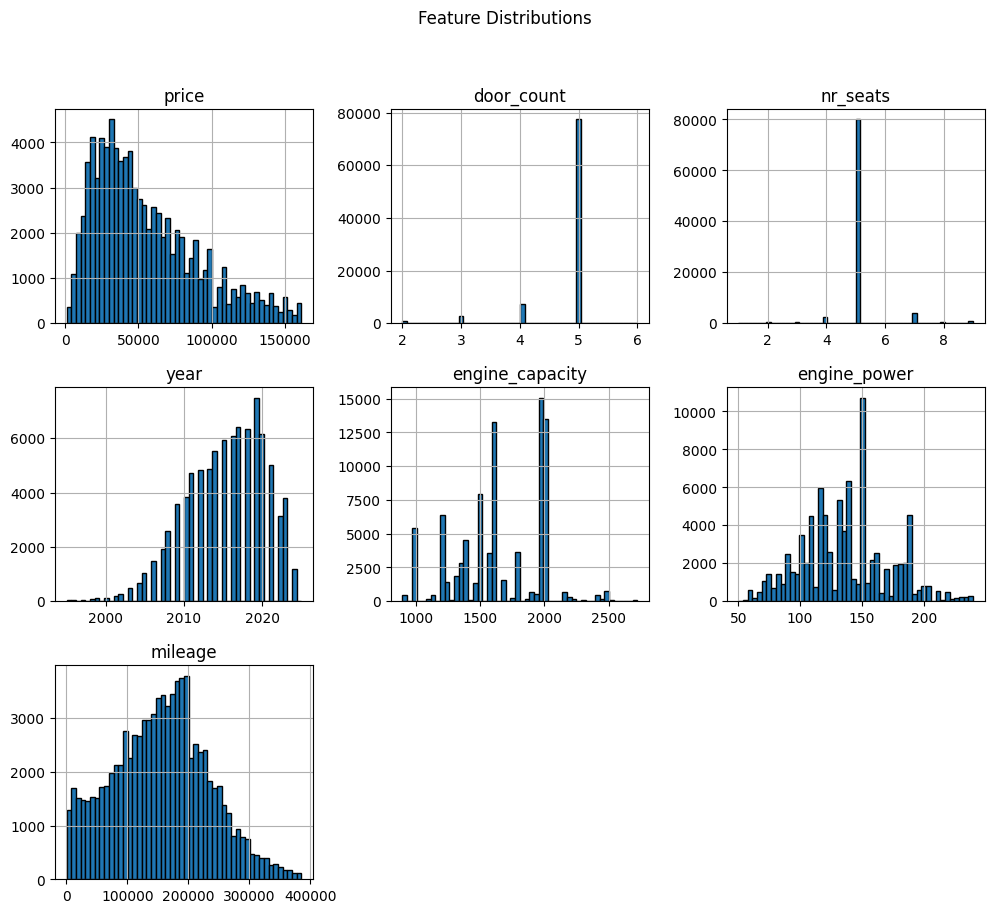

In [25]:
print(filtered_data.describe())

filtered_data.hist(figsize=(12, 10), bins=50, edgecolor='black')
plt.suptitle("Feature Distributions")
plt.show()

**Price:**  
- Most car prices concentrate below ~100,000 currency units.  
- The right tail is significantly reduced, but high-end vehicles still exist.  
- Peak distribution is around 20,000 - 80,000, making it the most common price range.  

**Next Step?** May be normalized (`log(mileage)`) to reduce skewness when working with a model.  

**Door Count:**  
- Dominated by 5-door cars (~80,000 entries), while 2, 3, and 4-door cars are rare.  

**Next Step?** This is not a strong predictor since it's mostly constant. Drop it when modelling.

**Number of Seats (`nr_seats`):**  
- Almost all cars have 5 seats.  
- 2-seater (sports cars) and 7+ seats (big cars) exist but are rare.  

**Next Step?** May be converted into a binary feature: **"5-seater or not."**  or just discarded in the future.

**Year:**  
- Normal distribution peaking around 2015-2020.  
- Few very old cars (~2000s) and new cars (~2025).  

**Engine Capacity:**  
- Highly certain values (probably due to the manufacturers).  
- Peaks at ~1600cm³, 2000cm³ (common for compact cars & sedans).  

**Next Step?** There is a chance that it could work better as a categorical variable (**low, mid, high**).  

**Engine Power:**  
- Near normal distribution, with peaks at ~140-160 HP (standard compact cars).  
**Next Step?** May be grouped into categories: **"low_power", "mid_power", "high_power".**  or other.

**Mileage:**  
- Bimodal shape: Peaks at low (~50k-100k km) and mid (~150k-200k km).  
- Cars with 350k+ km exist but are rare.  

**Next Step?** May be normalized (`log(mileage)`) to reduce skewness when working with a model.

#### Add features

In [26]:
filtered_data['car_age'] = 2025 - filtered_data['year']

filtered_data['mileage_per_year'] = filtered_data.apply(
    lambda row: row['mileage'] / (2025 - row['year']) if (2025 - row['year']) != 0 else np.nan,
    axis=1
)

**Car Age:**  
Provides a direct numeric measure of vehicle age.  

**Mileage per Year (Usage Intensity):**  
Helps predict price more accurately than raw mileage alone.  
Some cars are more heavily used than others, affecting their depreciation differently (for example taxis)

#### Feature Correlation Heatmap

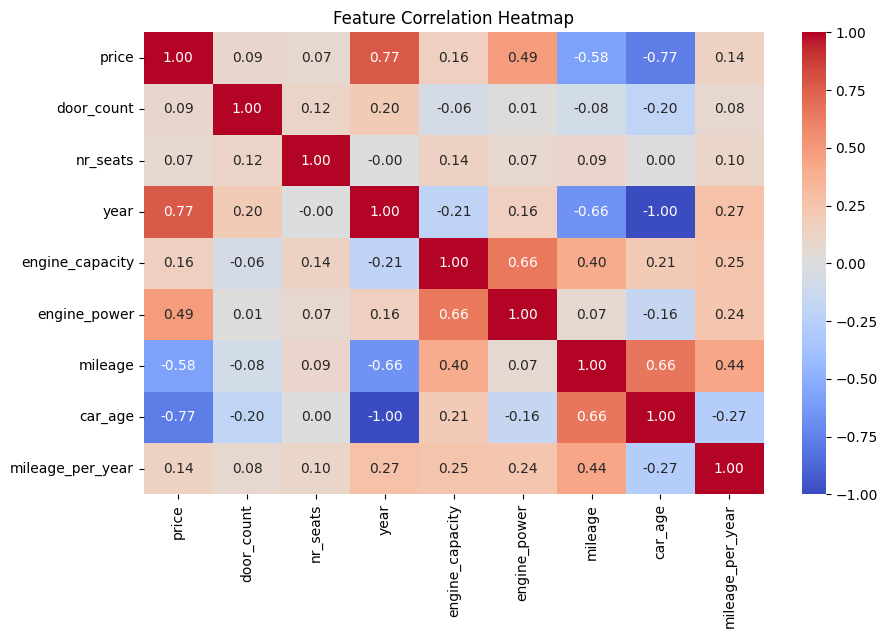

In [27]:
numeric_data = filtered_data.select_dtypes(include=['number'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

**Price:**  
- Strong correlation with year (**0.75**) → Newer cars tend to be more expensive.  
- Moderate correlation with engine power (**0.53**) → More powerful cars are generally pricier.  
- Negative correlation with mileage (**-0.61**) → Higher mileage lowers car price.  

**Door Count & Number of Seats:**  
- Weak correlation with price (**0.04 & 0.09**) → Likely not strong predictors.  
- Weak correlation with other features → Almost constant in the dataset.  
- **Next Step?** Dropping or transforming into a **[0,1]**.  

**Key Price Predictors:**  
- Year, mileage, and engine power have the strongest influence.  
- Newer, more powerful cars tend to have higher prices.  
- Higher mileage results in lower prices.  
- Older cars usually have more mileage, reinforcing the price drop.

### Price vs Mileage (color by 'year')

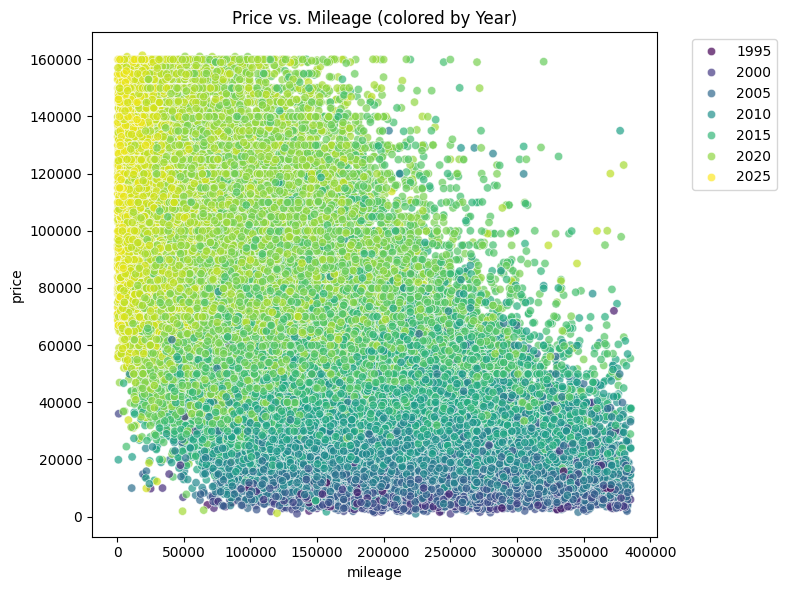

In [28]:
# PRICE vs. MILEAGE (color by 'year')
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=filtered_data,
    x='mileage',
    y='price',
    hue='year',
    palette='viridis',
    alpha=0.7
)
plt.title("Price vs. Mileage (colored by Year)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Mileage vs. Price (colored by year):**  
- As mileage increases (**x-axis**), price decreases (**y-axis**).  
- More recent model years (**yellow/green points**) cluster at higher prices.  
- Older cars (**purple/blue points**) are mostly in the lower-price range.  

- **Negative correlation** between price and mileage, as expected in the used-car market.  
- **Overlap in mid-range**: Some older cars retain value due to popularity.  
- **Justifies**  adding **"car_age"** or **"mileage_per_year"** to capture the combined effect of year and mileage on price.

### Price vs Mileage (color by 'fuel_type')

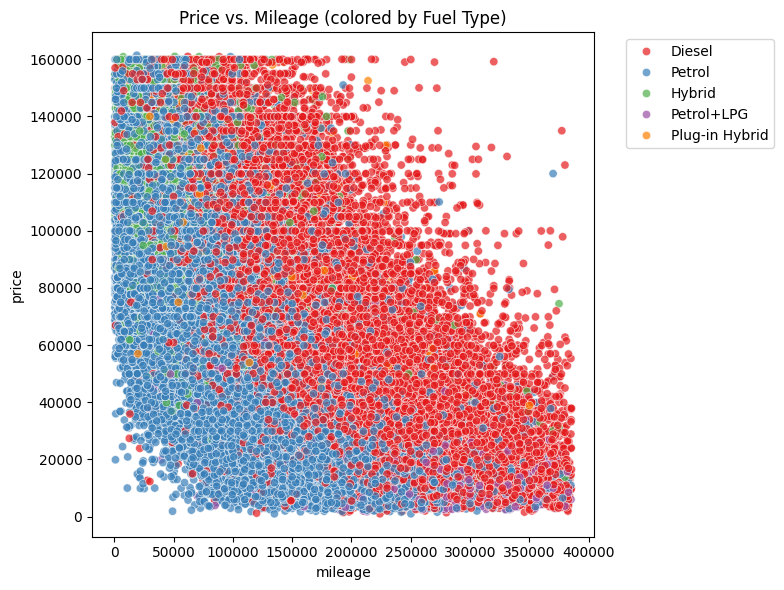

In [29]:
# PRICE vs. MILEAGE (color by 'fuel_type')
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=filtered_data,
    x='mileage',
    y='price',
    hue='fuel_type',
    palette='Set1',
    alpha=0.7
)
plt.title("Price vs. Mileage (colored by Fuel Type)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


**Price vs. Mileage by Fuel Type:**  
- **Negative slope**: Higher mileage generally leads to lower prices.  
- **Diesel cars** tend to have **higher mileage on average** and a **wider spread**.  
- **High-mileage vehicles (200,000+ km) with high prices** are mostly Diesel. Diesel cars are made for longer roads.
- **Petrol cars** dominate **lower mileage and lower price ranges**, suggesting they are more common for **city use** and resold at lower prices.  
- **Diesel cars** retain value better over higher mileage compared to Petrol.
- **Hybrid & Plug-in Hybrid** vehicles show **slower depreciation trends**, but they are less common in the dataset so for further inspection the dataset would have to expand.

### Price vs. Car Age & Price vs. Mileage per Year

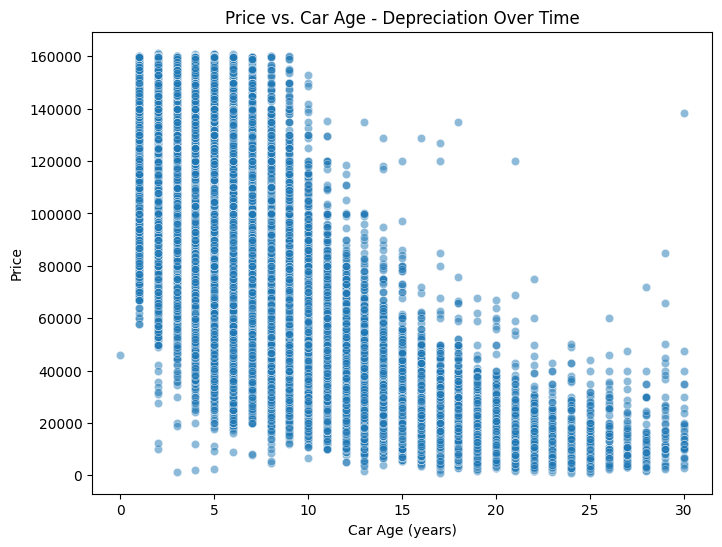

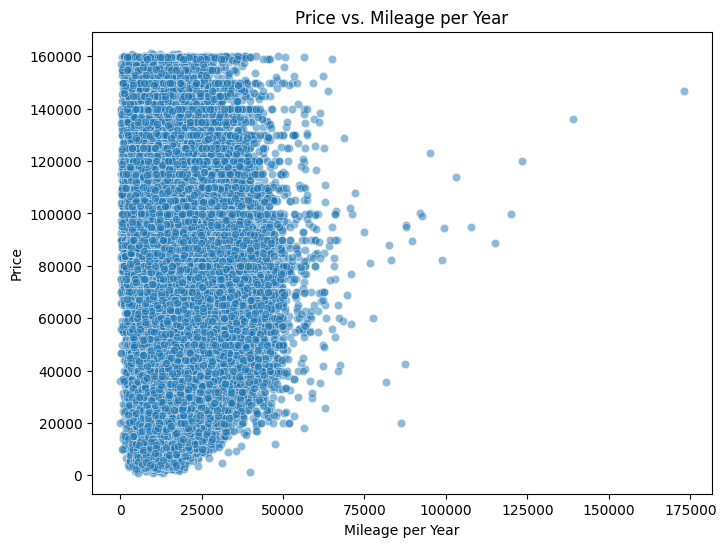

In [30]:
# Plot: Price vs. Car Age
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=filtered_data,
    x='car_age',
    y='price',
    alpha=0.5
)
plt.title("Price vs. Car Age - Depreciation Over Time")
plt.xlabel("Car Age (years)")
plt.ylabel("Price")
plt.show()

# Plot: Price vs. Mileage per Year
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=filtered_data,
    x='mileage_per_year',
    y='price',
    alpha=0.5
)
plt.title("Price vs. Mileage per Year")
plt.xlabel("Mileage per Year")
plt.ylabel("Price")
plt.show()

**Car Age vs. Price - Deprecation over time**:  
- **Strong negative correlation**: Older cars usually have lower prices.  
- Some **older models still hold value**, likely due to **popularity or rarity**.  

**Mileage per Year vs. Price:**  
- **Weaker correlation**: Mileage per year shows less clear correlation, suggesting price isn’t directly tied to mileage per year alone.
- Some cars may be **highly driven but still valuable**, indicating other factors influence price.

### Average Price by Car Make

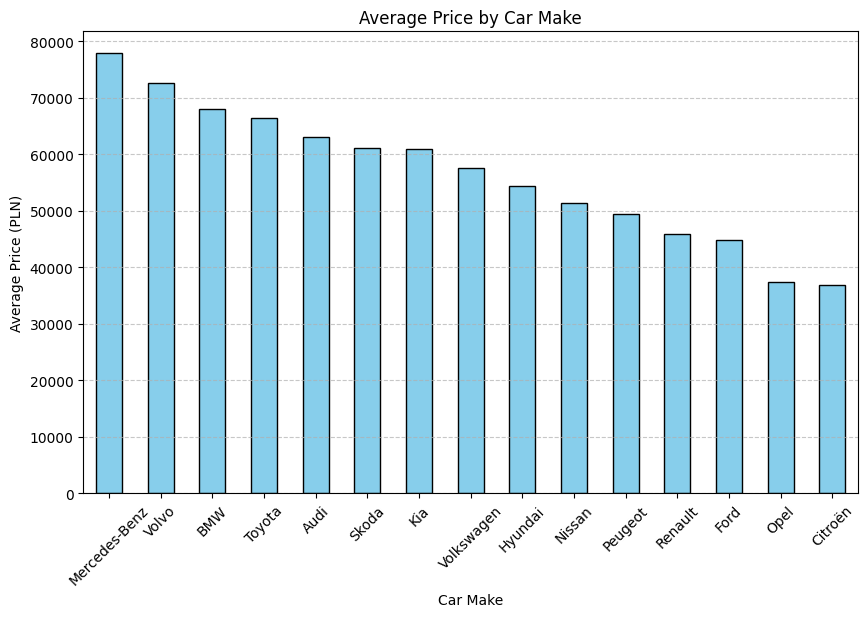

In [ ]:
avg_price_by_make = filtered_data.groupby('make')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
avg_price_by_make.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Car Make")
plt.ylabel("Average Price (PLN)")
plt.title("Average Price by Car Make")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


- **Citroën has the lowest average price**, indicating it is one of the most budget-friendly brands in the dataset.  
- **Luxury brands (Mercedes-Benz, Volvo, BMW)** have the highest average prices, exceeding **70,000 PLN**.  
- **Mid range brands (Toyota, Audi, Skoda)** are in the mid-range, averaging **55,000 PLN – 65,000 PLN**.  
- **Mass-market brands (Volkswagen, Hyundai, Nissan, Peugeot, Renault, Ford, Opel, Citroën)** have lower average prices, typically **under 50,000 PLN**.  

**What else does it mean?**
- **Luxury brands have significantly higher prices**, likely due to factors like performance, but also less measurable without external datasets like brand reputation.
- For our model that is predicting price, **brand should be a key feature**, as it very strongly influences car value.  

### Price Distribution by Fuel Type

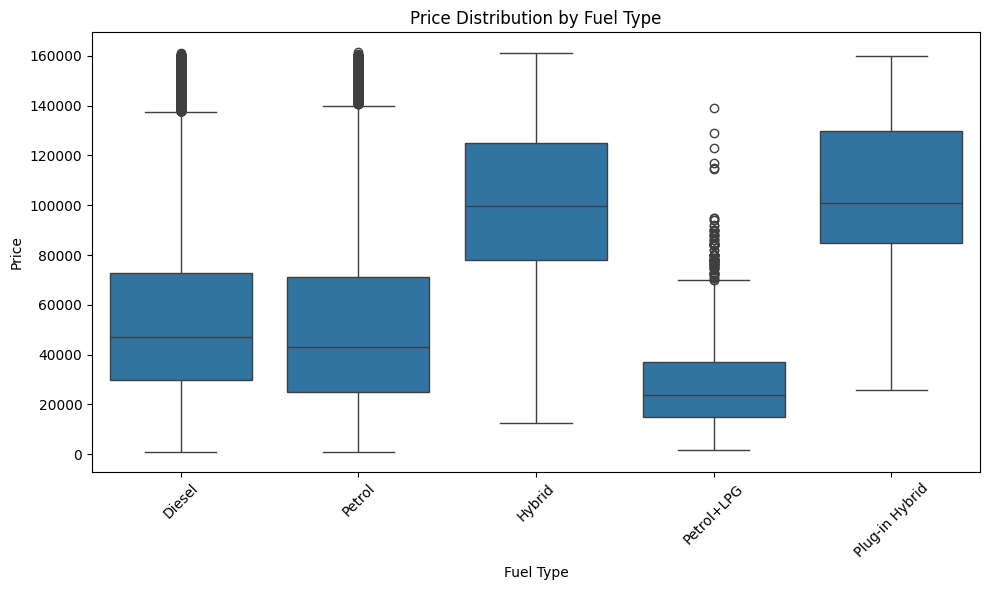

In [32]:
# Boxplot of price by fuel type
plt.figure(figsize=(10,6))
sns.boxplot(
    data=filtered_data,
    x='fuel_type',
    y='price (PLN)'
)
plt.xticks(rotation=45)
plt.title("Price Distribution by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


**Price Distribution by Fuel Type**
- **Hybrid and Plug-in Hybrid vehicles** have the **highest median price** and a wider price range.
- **Diesel and Petrol cars** have similar median prices but show many **high-value outliers** (luxury models).
- **Petrol + LPG vehicles** have the **lowest median price**, with a **narrow price range**, suggesting they are more budget-friendly.
- **Hybrid and Plug-in Hybrid vehicles show fewer extreme outliers**, indicating a **more consistent price range** compared to petrol/diesel.

**What does it mean?**  
- Hybrid and Plug-in Hybrid cars tend to be **higher-end models**, leading to their **higher price points**.  
- Petrol + LPG cars are likely **budget-friendly economy vehicles**, with less price variation.


### Price Distribution by Gearbox Type

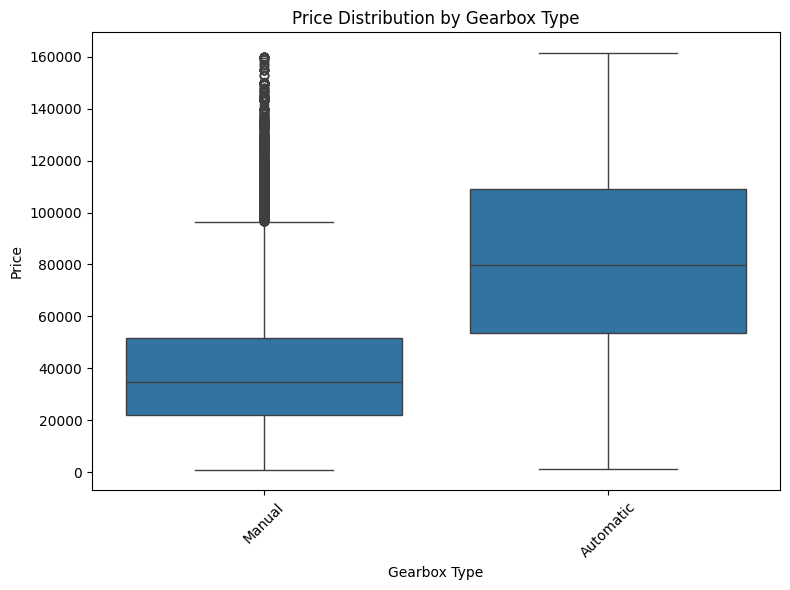

In [33]:
# Boxplot of price by gearbox type
plt.figure(figsize=(8,6))
sns.boxplot(
    data=filtered_data,
    x='gearbox',
    y='price (PLN)'
)
plt.xticks(rotation=45)
plt.title("Price Distribution by Gearbox Type")
plt.xlabel("Gearbox Type")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

**Price Distribution by Gearbox Type**
- **Automatic cars are significantly more expensive than manual cars** on average.
- The **median price for automatic cars is nearly double that of manual cars!!**
- **Manual cars show many low-priced models**, with a high number of outliers in the **upper price range** (likely performance cars).
- **Automatic cars have a more evenly distributed price range** with fewer extreme outliers.

**What does it mean?:**  
- **Automatic gearboxes are associated with higher-end vehicles**, including **luxury and hybrid cars**, which **inflates their price**.
- **Manual cars remain popular in lower-budget and performance-oriented segments**, leading to a **wider price distribution**.

### Average price difference between manual and automatic gearbox

In [34]:
avg_price_automatic = filtered_data[filtered_data['gearbox'] == 'Automatic']['price'].mean()
avg_price_manual = filtered_data[filtered_data['gearbox'] == 'Manual']['price'].mean()

price_difference = avg_price_automatic - avg_price_manual
percentage_difference = (price_difference / avg_price_manual) * 100

log_message = f"On average, automatic cars cost approximately {price_difference:.2f} more than manual cars, which represents a {percentage_difference:.2f}% price increase."

print(log_message)

On average, automatic cars cost approximately 42541.36 more than manual cars, which represents a 108.24% price increase.


### Car Price Distribution by Make and Year (log scale)

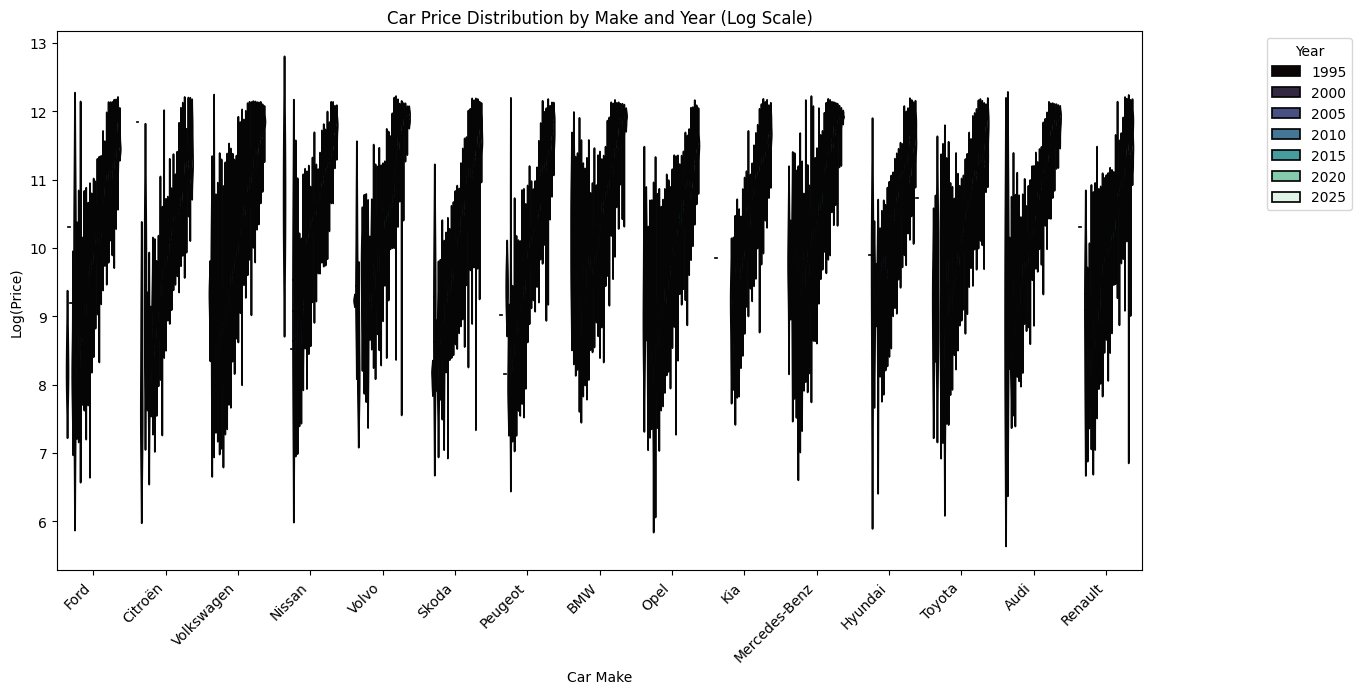

In [35]:
# Apply log transformation to price for better distribution visualization
filtered_data['log_price'] = np.log1p(filtered_data['price'])

plt.figure(figsize=(14, 7))
sns.violinplot(data=filtered_data, x='make', y='log_price', hue='year', palette='mako', density_norm='width', inner='quartile')

plt.xticks(rotation=45, ha='right')  
plt.xlabel("Car Make")
plt.ylabel("Log(Price)")
plt.title("Car Price Distribution by Make and Year (Log Scale)")
plt.legend(title="Year", loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()


**Car Price Distribution by Make and Year (Log Scale)**

- **Older cars (1995-2005)** show a wider price spread, likely due to depreciation and varying conditions.  
- **Newer models (2015-2025)** tend to have higher prices, reflecting inflation and newer features.  

**Brand-Specific Observations:**
- **Luxury brands (Mercedes-Benz, BMW, Audi)** consistently hold higher price points across all years.  
- **Mainstream brands (Volkswagen, Toyota, Nissan)** display a more balanced price distribution, likely due to a mix of economy and premium models.  
- **Budget brands (Renault, Citroën, Skoda)** generally stay in the lower price range, suggesting affordability and lower depreciation.  

**General Trends:**
- Prices show **logarithmic scaling**, indicating that price variations are more pronounced at higher price points.  
- Some brands have **more variation** in pricing within a given year, possibly due to multiple model lines and configurations.  


### Is there a manufacturer that dominates one type of transmission?

<Figure size 1200x600 with 0 Axes>

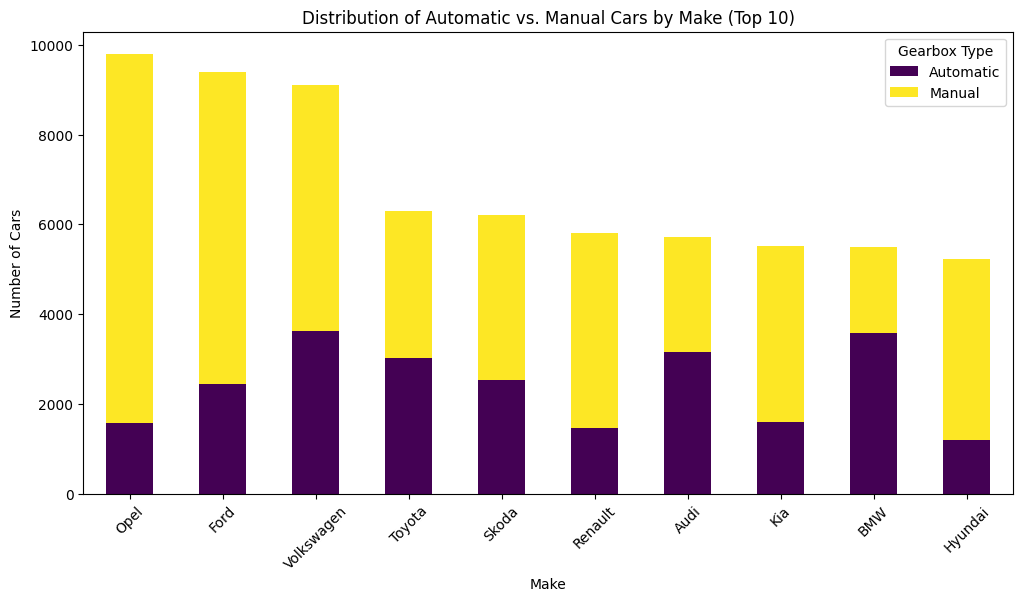

In [36]:

make_transmission_counts = filtered_data.groupby(['make', 'gearbox']).size().unstack()

make_transmission_counts = make_transmission_counts.fillna(0)

make_transmission_counts['Total'] = make_transmission_counts.sum(axis=1)
make_transmission_counts = make_transmission_counts.sort_values(by='Total', ascending=False)

top_10_makes = make_transmission_counts.head(10)

# chart for top 10 makes Automatic vs. Manual distribution
plt.figure(figsize=(12,6))
top_10_makes[['Automatic', 'Manual']].plot(kind='bar', stacked=True, figsize=(12,6), colormap="viridis")

plt.title("Distribution of Automatic vs. Manual Cars by Make (Top 10)")
plt.xlabel("Make")
plt.ylabel("Number of Cars")
plt.xticks(rotation=45)
plt.legend(title="Gearbox Type")
plt.show()


**Opel, Ford, and Volkswagen**  
- These brands have the **highest** total car counts.  
- The **majority** of their vehicles are **manual** (yellow bars are significantly larger than purple bars).  
- **Opel** has the **most** manual cars, suggesting it may be more common in **lower-budget** markets.

**Toyota and Skoda**  
- These brands have a **more balanced** distribution of transmissions.  
- **Toyota**, in particular, has a **noticeable** share of **automatic** cars.

**BMW and Audi**  
- These brands **dominate** in **automatic** cars, aligning with their reputation as **premium** brands.  
- The **manual** count is **lower**, implying that most **models** (especially **recent** ones) come with **automatic** transmissions.

**Hyundai and Renault**  
- **Renault** follows the general pattern of having more **manual** cars.  
- **Hyundai** has a relatively **smaller** share of **manual** cars compared to others.

**Overall Observations**  
- **Luxury** brands (BMW, Audi) **favor** automatics, while **budget** brands (Opel, Ford) have more **manual** cars.  
- **Toyota** and **Skoda** have a relatively **balanced** mix, likely depending on **market** and **model**.  
- **Volkswagen**, despite its strong reputation, still has a **significant** number of **manual** cars, possibly due to its **very** broad model lineup and the popularity of the **"golf trojka"** in **Poland**.

### Gearbox (transmission) trends over time

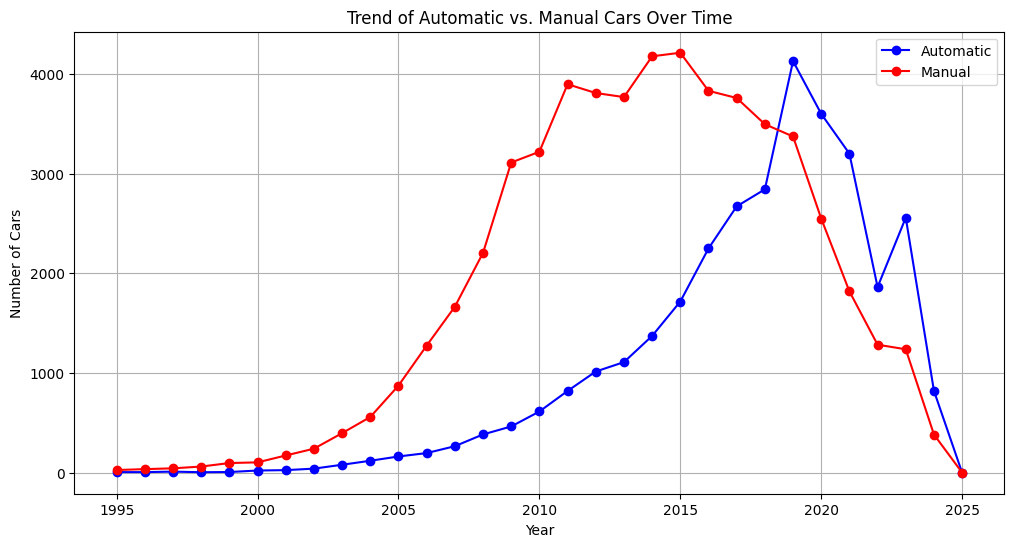

In [37]:
transmission_trends = filtered_data.groupby(['year', 'gearbox']).size().unstack()

transmission_trends = transmission_trends.fillna(0)

# trend over years
plt.figure(figsize=(12,6))
plt.plot(transmission_trends.index, transmission_trends['Automatic'], label='Automatic', color='blue', marker='o')
plt.plot(transmission_trends.index, transmission_trends['Manual'], label='Manual', color='red', marker='o')

plt.title("Trend of Automatic vs. Manual Cars Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Cars")
plt.legend()
plt.grid(True)
plt.show()

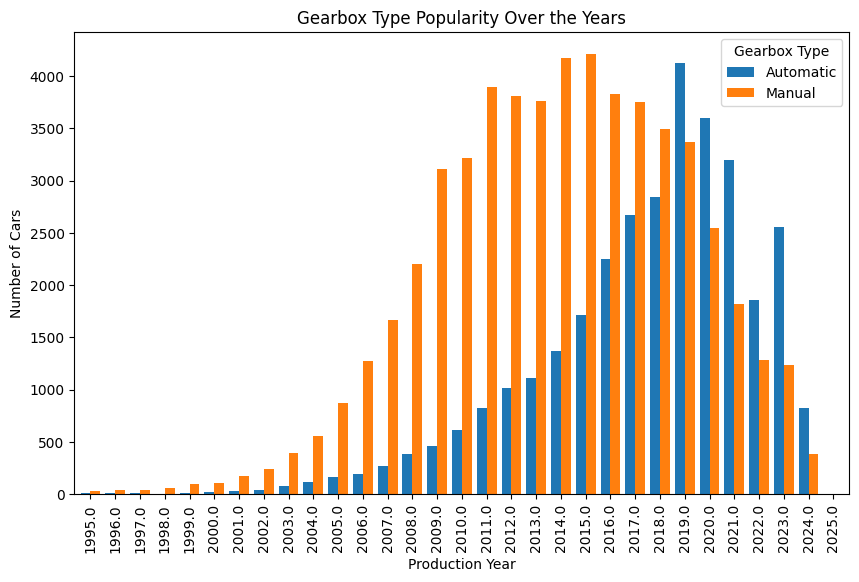

In [38]:
gearbox_counts = filtered_data.groupby(["year", "gearbox"]).size().reset_index(name="Count")

gearbox_pivot = gearbox_counts.pivot(index="year", columns="gearbox", values="Count").fillna(0)

ax = gearbox_pivot.plot(
    kind="bar",
    figsize=(10, 6),
    width=0.8  #
)

plt.title("Gearbox Type Popularity Over the Years")
plt.xlabel("Production Year")
plt.ylabel("Number of Cars")
plt.legend(title="Gearbox Type")

plt.show()

- **Manual** cars **dominated** before **2010**, but their numbers **peaked** around **2012–2015** and have since **declined**.  
- **Automatic** cars have been **rising** steadily, **surpassing** manual cars around **2018–2019**.  
- **Post-2020**, manual cars are rapidly **disappearing**, while automatics **dominate**.  
- The **huge** dip after **2020** may suggest two things:  
  - **Lower car availability due to COVID-19 and inflation**  
  - **Polish people usually buy older cars**

### How brand market share changed over time? (Top 10 Brands) - Market Share Trends

<Figure size 1200x600 with 0 Axes>

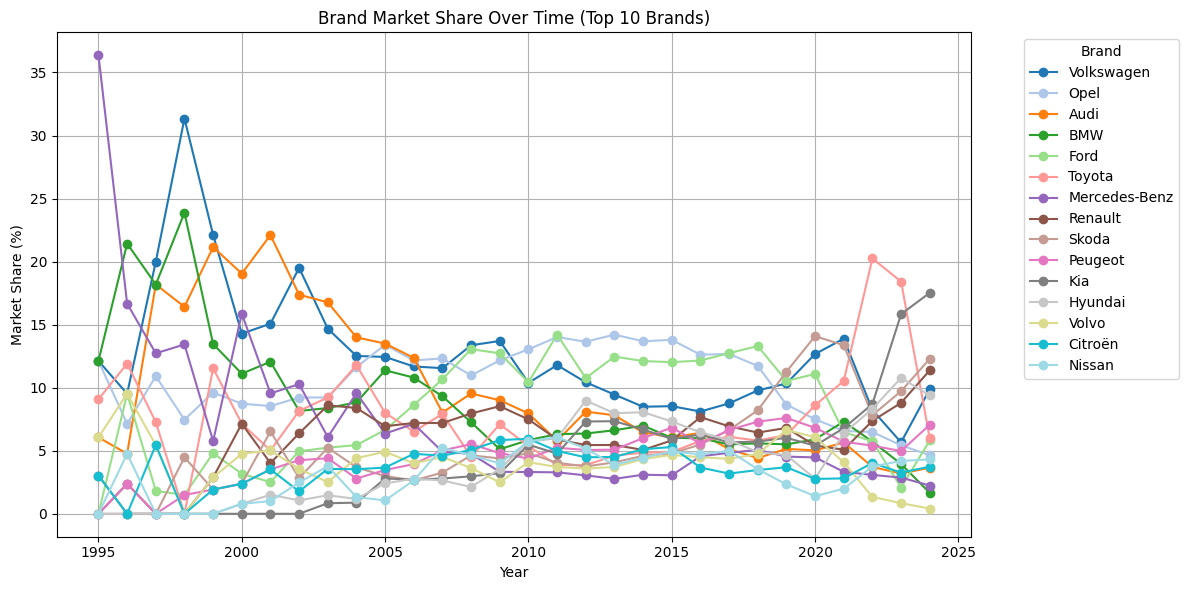

In [39]:
market_share_by_year = filtered_data.groupby(['year', 'make']).size().unstack(fill_value=0)

# Normalize market share by year to get the percentage of each brand's share per year
market_share_percentage = market_share_by_year.div(market_share_by_year.sum(axis=1), axis=0) * 100
market_share_percentage_filtered = market_share_percentage[market_share_percentage.index < 2025]


brands = market_share_percentage_filtered.mean(axis=0).sort_values(ascending=False).index
plt.figure(figsize=(12,6))
market_share_percentage_filtered[brands].plot(kind='line', figsize=(12,6), marker='o', colormap="tab20")

plt.title("Brand Market Share Over Time (Top 10 Brands)")
plt.xlabel("Year")
plt.ylabel("Market Share (%)")
plt.legend(title="Brand", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

- Some brands that had **high market shares** in the **late 1990s** (e.g., **Opel**, **Volkswagen**, **Audi**) saw a **gradual decline** over time.  
- Brands like **Toyota**, **Kia**, and **Skoda** showed a **steady increase** in market share in **recent years**.  
- No single brand **dominates** the market **significantly** now, as market shares appear more **evenly distributed** across multiple brands.

### Distribution of Engine Power & Engine Capacity

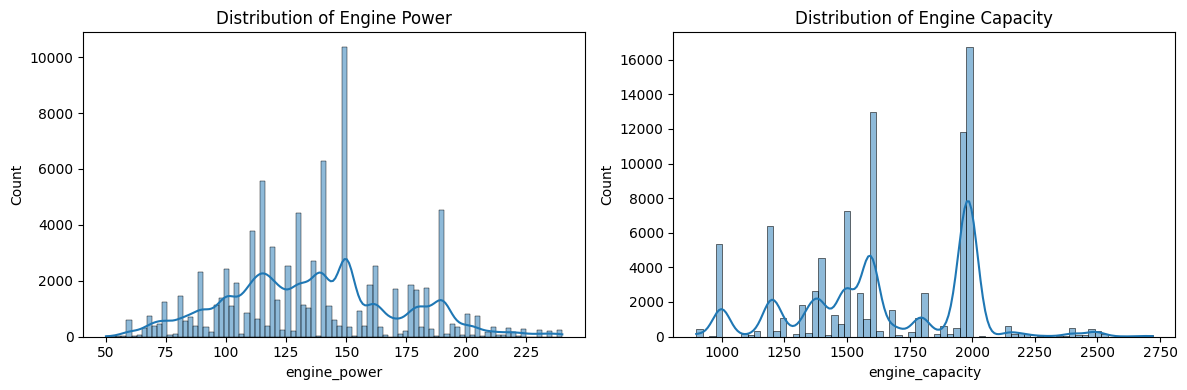

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=filtered_data, x='engine_power', kde=True, ax=axes[0])
axes[0].set_title("Distribution of Engine Power")

sns.histplot(data=filtered_data, x='engine_capacity', kde=True, ax=axes[1])
axes[1].set_title("Distribution of Engine Capacity")

plt.tight_layout()
plt.show()

- **Engine Power**:  
  - The **density** curve indicates multiple **peaks**, suggesting different engine power segments (e.g., **small**, **mid-size**, and **high-performance** engines).

- **Engine Capacity**:  
  - The highest **peak** is around **2000cc**, indicating a high **prevalence** of engines with this **displacement**.

- Both distributions show **clustered** peaks, likely due to **market preferences** and **manufacturer standards**.  
- The **right skew** in both charts suggests **fewer** vehicles with **extremely high** engine power and capacity.

### Engine Power vs. Engine Capacity by Make

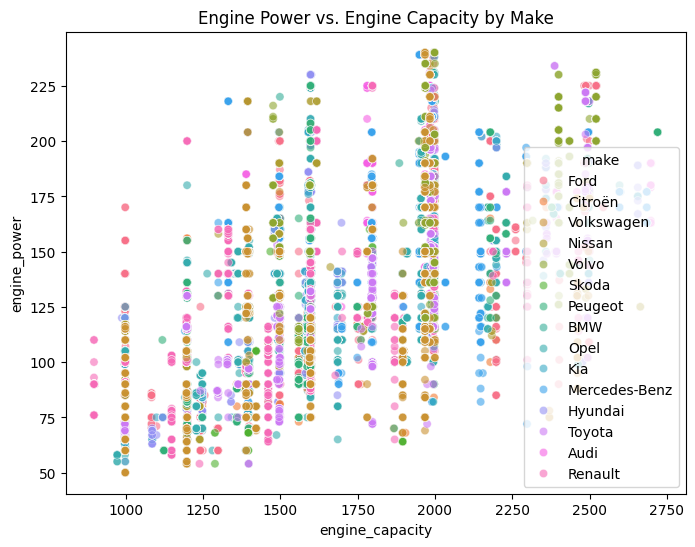

In [41]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=filtered_data,
    x='engine_capacity', 
    y='engine_power',
    hue='make',        
    alpha=0.6
)
plt.title("Engine Power vs. Engine Capacity by Make")
plt.show()

- Brands like **BMW**, **Mercedes-Benz**, and **Audi** (often **performance-oriented**) appear more frequently in the **higher** power and capacity ranges.  
- Some cars with **smaller** engines still have **relatively high** power (above **150 hp**), indicating **turbocharged** or **performance** variants.

### Engine Power vs. Engine Capacity by Price

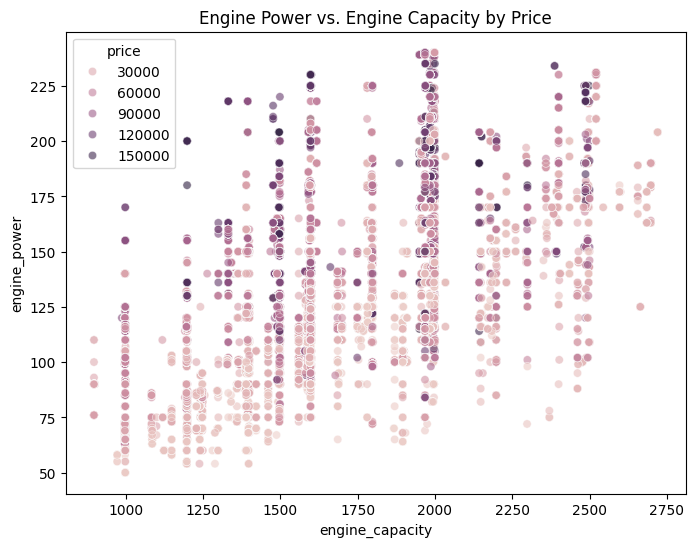

In [42]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=filtered_data,
    x='engine_capacity', 
    y='engine_power',
    hue='price',        
    alpha=0.6
)
plt.title("Engine Power vs. Engine Capacity by Price")
plt.show()

- Vehicles with **1500-2000cm³** and **100-175hp** (**mid range** cars) show a **mix** of price levels, suggesting that **brand**, **features**, or **premium materials** impact pricing beyond **raw engine specs**.  
- **Lighter-colored** dots dominate the **1000-1400cm³** and **50-125hp** range, aligning with more **budget-friendly** vehicles.  
- The highest concentration of **high-priced** vehicles is found at **2000cm³** and **200hp+**, likely representing **luxury** and **performance** cars.

- **Key Takeaways** from both scatterplots:
  - There are **significant** price differences even for cars with **similar** engine specs, suggesting factors beyond engine power and capacity — such as **technology**, **brand reputation**, and **luxury features**—play a role in **pricing**.
  - The **1500-2000cm³** and **100-175hp** range has a **mix** of both **premium** (**BMW**, **Audi**) and **mainstream** brands (**Toyota**, **Ford**, **Skoda**), indicating that **mid-range** vehicles come with varying **features** and **brand influences**.

### Median Price by Top 50 Make-Model combinations

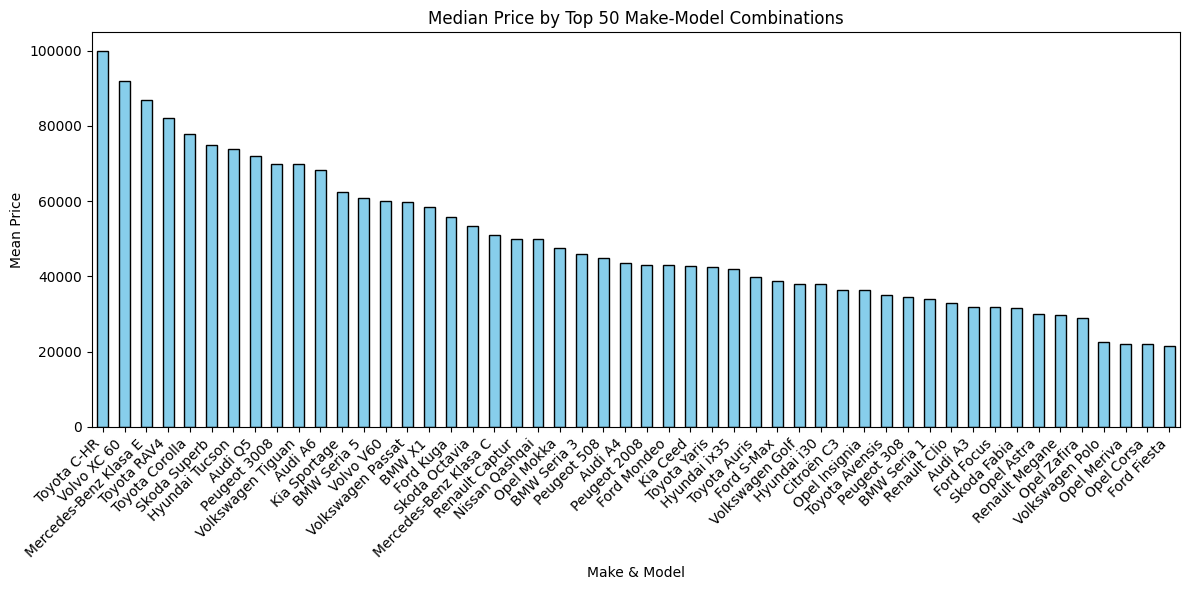

In [43]:
#  top 50 most common models
top_models = filtered_data['model'].value_counts().head(50).index
subset = filtered_data[filtered_data['model'].isin(top_models)].copy()

subset.loc[:, "make_model"] = subset["make"] + " " + subset["model"]

model_price = subset.groupby("make_model")["price"].median().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 6))
model_price.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Median Price by Top 50 Make-Model Combinations")
plt.xlabel("Make & Model")
plt.ylabel("Mean Price")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- **Toyota C-HR, Mercedes-Benz GLE, and Toyota RAV4** are the most expensive models, with median prices exceeding **90,000 PLN**.  
- **Volkswagen, Hyundai, Peugeot, and Renault models** are more affordable, with median prices generally below **40,000 PLN**.  
- **Ford Fiesta and Opel Meriva have the lowest median prices**, making them the most budget-friendly models.  
- The **distribution is right-skewed**, meaning a few high-priced models push the median up.

**What else does it mean?**
- **Brand reputation and vehicle type (so here - engine stats) impact price**, with SUVs and luxury brands having the highest prices.
- **Mass-market brands like Opel, Renault, and Ford** dominate the lower end of the price range, likely due to their focus on economy cars and old models still being popular.



### Price distribution per model - Top 50 the most frequently listed

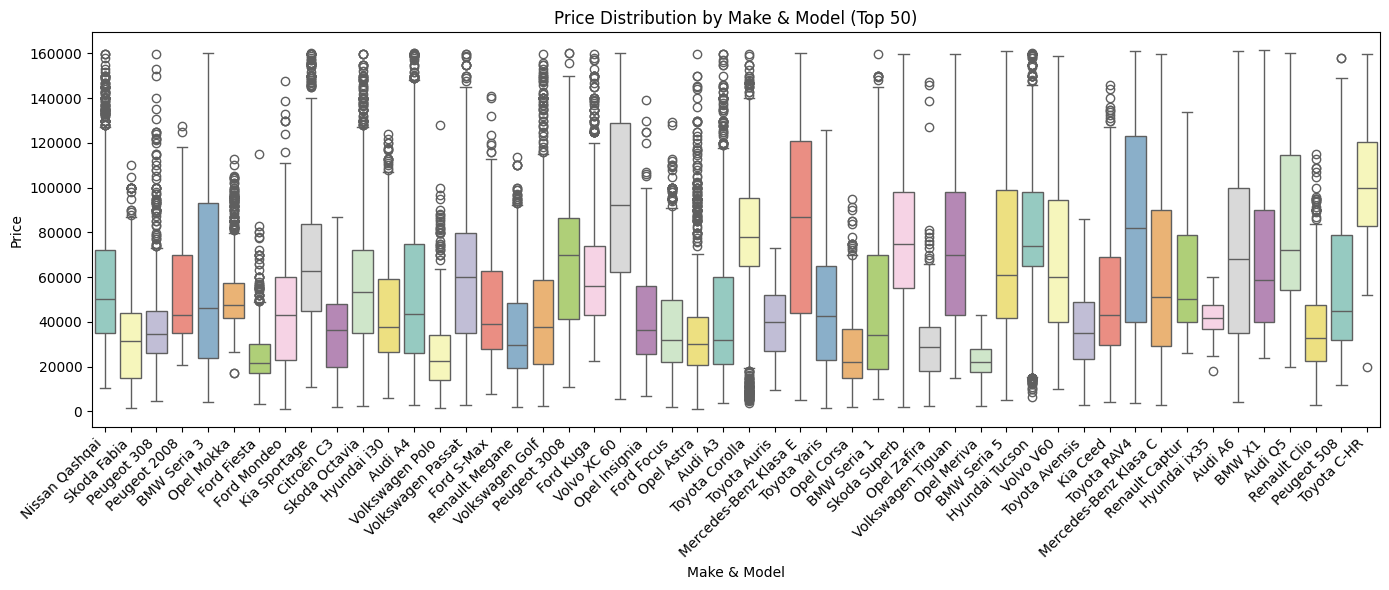

In [44]:
subset = subset.copy() 
subset["make_model"] = subset["make"] + " " + subset["model"]

plt.figure(figsize=(14, 6))

sns.boxplot(data=subset, x="make_model", y="price", hue="make_model", palette="Set3", legend=False)

plt.title("Price Distribution by Make & Model (Top 50)")
plt.xlabel("Make & Model")
plt.ylabel("Price")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Some models, like **Toyota C-HR, Mercedes-Benz GLE, and BMW 3-Series**, have **higher median prices** and **larger price spreads**, likely due to multiple trim levels.  
- Economy cars like **Opel Meriva, Ford Fiesta, and Renault Clio** have **lower median prices** with relatively **smaller spreads**, indicating a more uniform price range.  
- **Outliers are present in most models**, showing that some cars are priced significantly higher or lower than the majority.  

What does it mean?
- **Luxury models tend to have higher price variability**, possibly due to trim levels offered by manufacturers.
- **Budget-friendly models exhibit more consistency**, suggesting they are often sold in standard configurations.

**Idea for next steps:**  
- **Analyzing other influencing factors** like fuel type or engine power may be a good idea to understand pricing trends within each manufacturer.


### Fuel Type Influence on Prices Across Top 12 Manufacturers


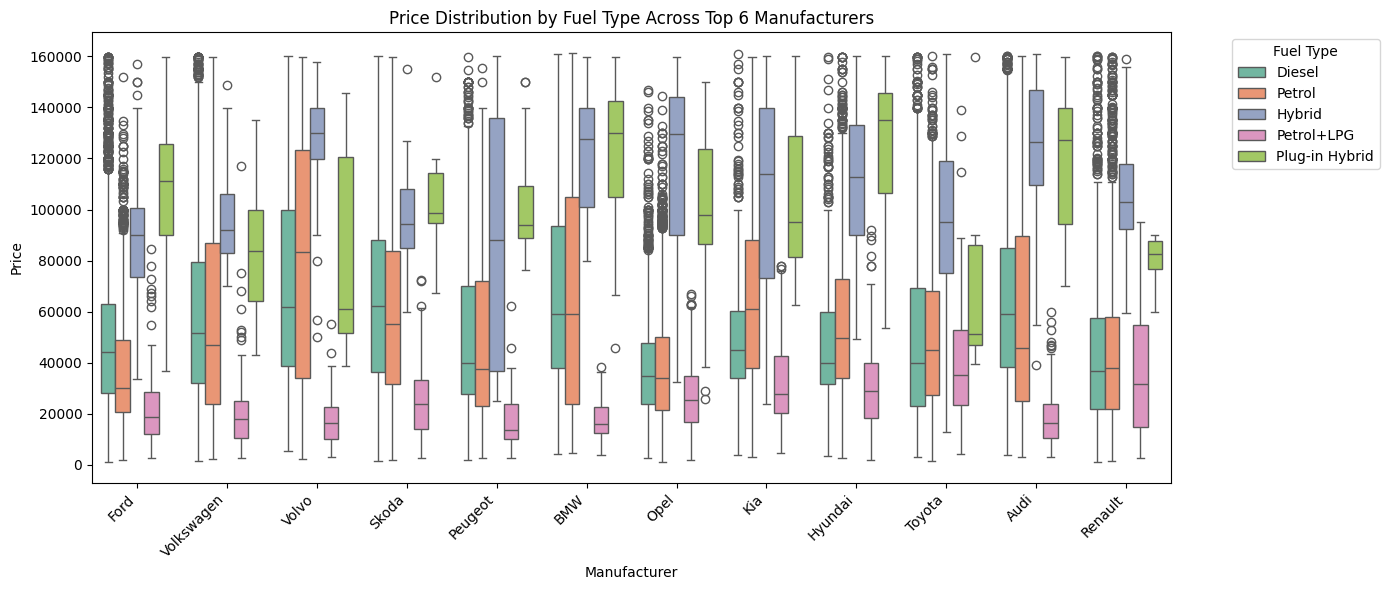

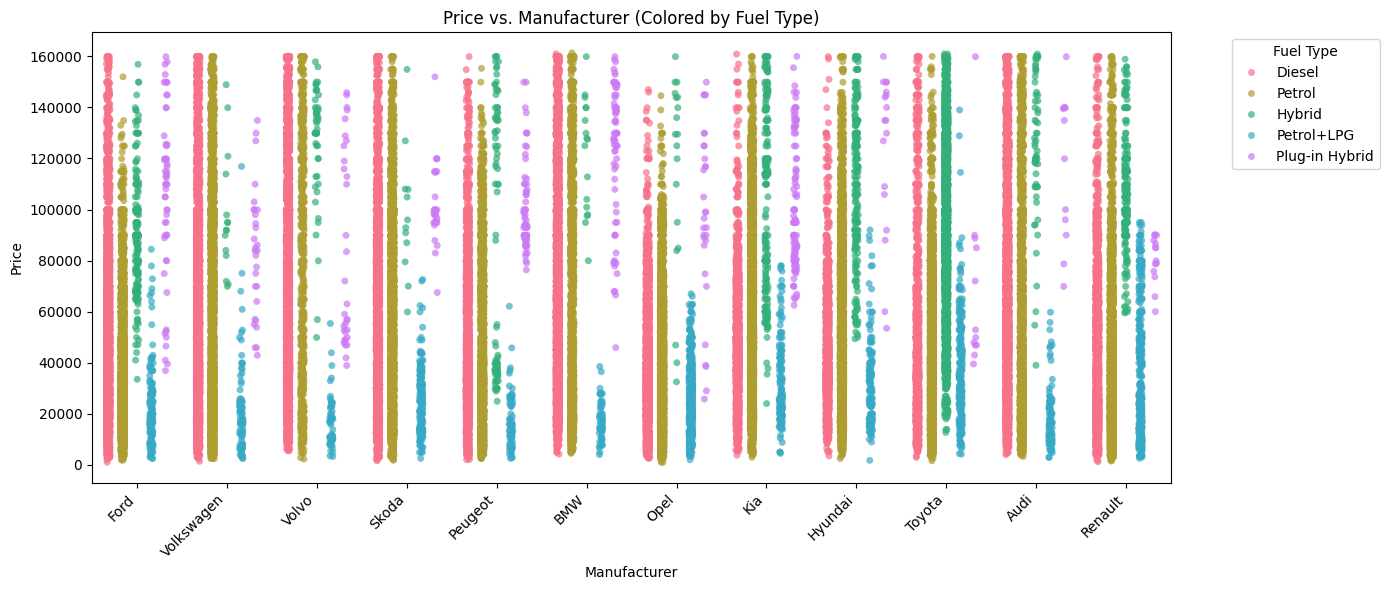

In [ ]:
top_12_makes = filtered_data["make"].value_counts().head(12).index
subset = filtered_data[filtered_data["make"].isin(top_12_makes)]

plt.figure(figsize=(14, 6))

# Box plot grouped by manufacturer and split by fuel type
sns.boxplot(data=subset, x="make", y="price", hue="fuel_type", palette="Set2")

plt.title("Price Distribution by Fuel Type Across Top 6 Manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Price")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))

# Scatterplot for price comparison across manufacturers by fuel type
sns.stripplot(data=subset, x="make", y="price", hue="fuel_type", dodge=True, palette="husl", alpha=0.7)

plt.title("Price vs. Manufacturer (Colored by Fuel Type)")
plt.xlabel("Manufacturer")
plt.ylabel("Price")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

**Box Plot: Price Distribution by Fuel Type per Manufacturer**
- **Diesel & Hybrid vehicles tend to have higher median prices** across most manufacturers.
- **Plug-in Hybrids consistently show high price ranges**, reflecting their premium status.
- **Petrol cars have wider price variability**, with many affordable options.
- **Petrol+LPG vehicles are the cheapest** among all fuel types, likely due to lower demand or specific market positioning.
- **Premium brands (e.g., BMW, Audi, Volvo) show high pricing for all fuel types**, while economy brands (e.g., Ford, Skoda, Peugeot) have lower-priced distributions.

**Brand-Specific Observations:**
- **BMW & Audi:** Diesel and Hybrid vehicles dominate the higher price ranges.
- **Toyota:** Higher hybrid presence, reflecting its strong market position in hybrid technology.
- **Volkswagen & Peugeot:** Diesel and Petrol vehicles are the most common, but Diesel holds value better.
- **Renault & Skoda:** The presence of Plug-in Hybrids may shows recent market shifts toward electrification but data is sparse.

**Scatter Plot: Price vs. Manufacturer (Colored by Fuel Type)**
- **Fuel type influences price trends across manufacturers but varies significantly within brands.**
- **Luxury brands (BMW, Audi, Volvo) have a wider spread in prices**, meaning there are both high-end and budget-friendly models.
- **Economy brands (Ford, Peugeot, Renault) have tighter price clusters**, meaning pricing differences between fuel types are less extreme.
- **Petrol remains the most common fuel type across all price levels**, while Diesel is more dominant in certain mid-to-high price ranges.
- **Hybrid and Plug-in Hybrid vehicles cluster in higher price brackets**, reinforcing their premium status and being a new car.



### Price distribution by Color

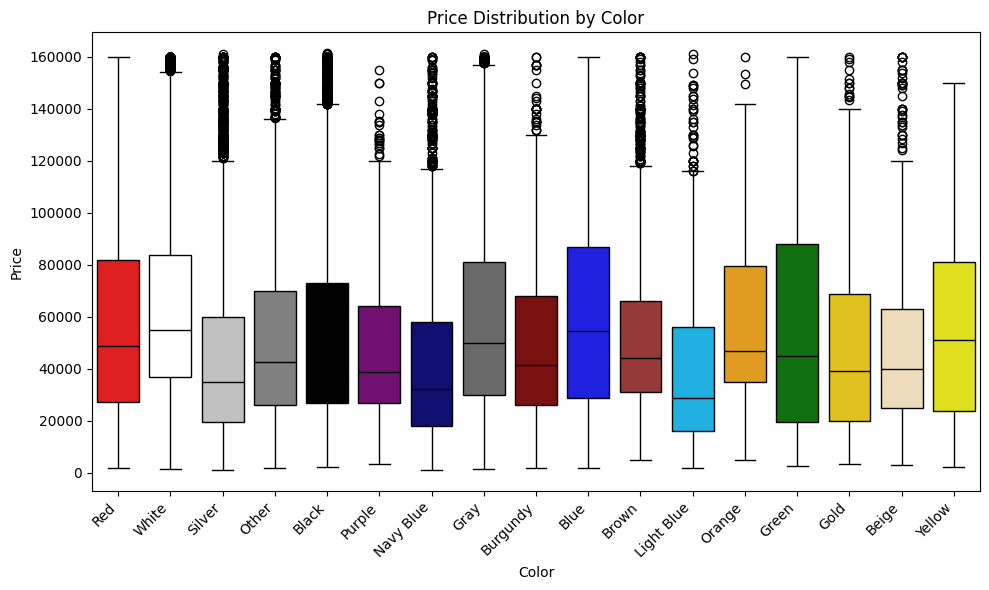

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Price Distribution by Color")
plt.xlabel("Color")
plt.ylabel("Price")
plt.xticks(rotation=45, ha='right')
# bar chart for color distribution
sns.boxplot(data=filtered_data, x="color", y="price", palette=color_mapping_plt, hue="color", legend=False)

plt.tight_layout()
plt.show()

- **Most colors exhibit similar median prices**, suggesting that color does not significantly impact car pricing.  
- **Less common colors like Burgundy, Gold, and Beige** show a **wider spread in pricing**, but probably due to fewer listings and niche demand.
- **Bright colors (Yellow, Orange, Green) tend to have more extreme price variations**, likely representing rare cars.

### Is mileage less damaging to price for Diesel cars than for Petrol cars?

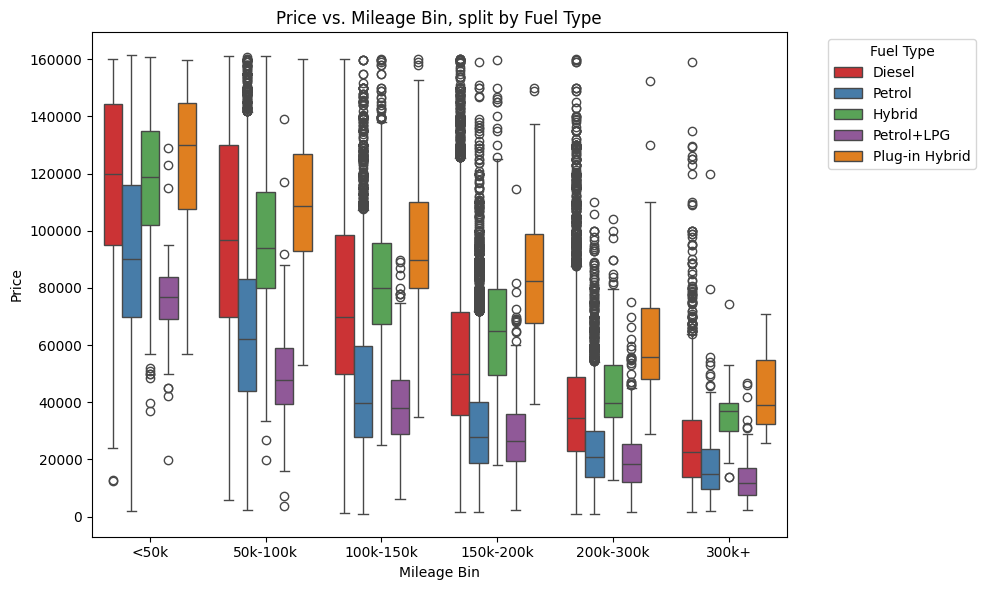

In [47]:
filtered_data['mileage_bin'] = pd.cut(
    filtered_data['mileage'],
    bins=[0, 50000, 100000, 150000, 200000, 300000, np.inf],
    labels=["<50k", "50k-100k", "100k-150k", "150k-200k", "200k-300k", "300k+"]
)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_data, 
    x='mileage_bin', 
    y='price', 
    hue='fuel_type', 
    palette='Set1'
)
plt.title("Price vs. Mileage Bin, split by Fuel Type")
plt.xlabel("Mileage Bin")
plt.ylabel("Price")
plt.legend(title="Fuel Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**tl;dr - Yes!**

**Diesel cars (red) generally maintain a higher median price than Petrol (blue)** across all mileage bins.  
   - This suggests that **Diesels hold value better**, likely due to their **perceived durability** and **fuel efficiency**, especially for high-mileage drivers which is a well known  fact for buyers. 

**Petrol cars are the most common** but experience **steeper price depreciation** as mileage increases.  
   - This could be due to a combination of **higher availability** and **shorter lifespan compared to Diesel**. 

**Hybrid and Plug-in Hybrid cars show varied price behavior**:  
   - They often appear **more expensive in lower mileage bins**, reflecting their **higher initial purchase price**.  
   - However, depreciation trends are **less clear**, possibly due to **lower sample size** in this dataset.  

**Higher mileage bins generally show lower median prices**, reflecting **expected depreciation trends**.  
   - **Cars with over 150,000 km tend to have significantly lower prices, regardless of fuel type.**

### Engine Power vs. Price Across Top 6 Manufacturers (by the count)

Average Price by Make and Engine Power Bin:

power_bin           0-100hp     101-150hp     151-200hp      201-300hp
make                                                                  
Audi           26371.253012  55109.217404  64799.522462   97867.168093
BMW            38492.307692  55737.282398  77849.868618   77207.847775
Citroën        27972.998972  38571.697549  48130.718578   77000.428333
Ford           23958.561872  44046.143928  60938.630530   76616.067000
Hyundai        34373.650118  54869.286074  76037.716107  122883.222222
Kia            39004.966171  58526.581023  86353.493025   93576.792138
Mercedes-Benz  27011.964127  55996.372130  91509.288514   92703.504941
Nissan         25123.962166  46085.958186  86806.143471   77283.333333
Opel           25729.671230  38638.481734  45003.089837   55611.513462
Peugeot        25759.340901  51769.524351  63790.644311   81768.583380


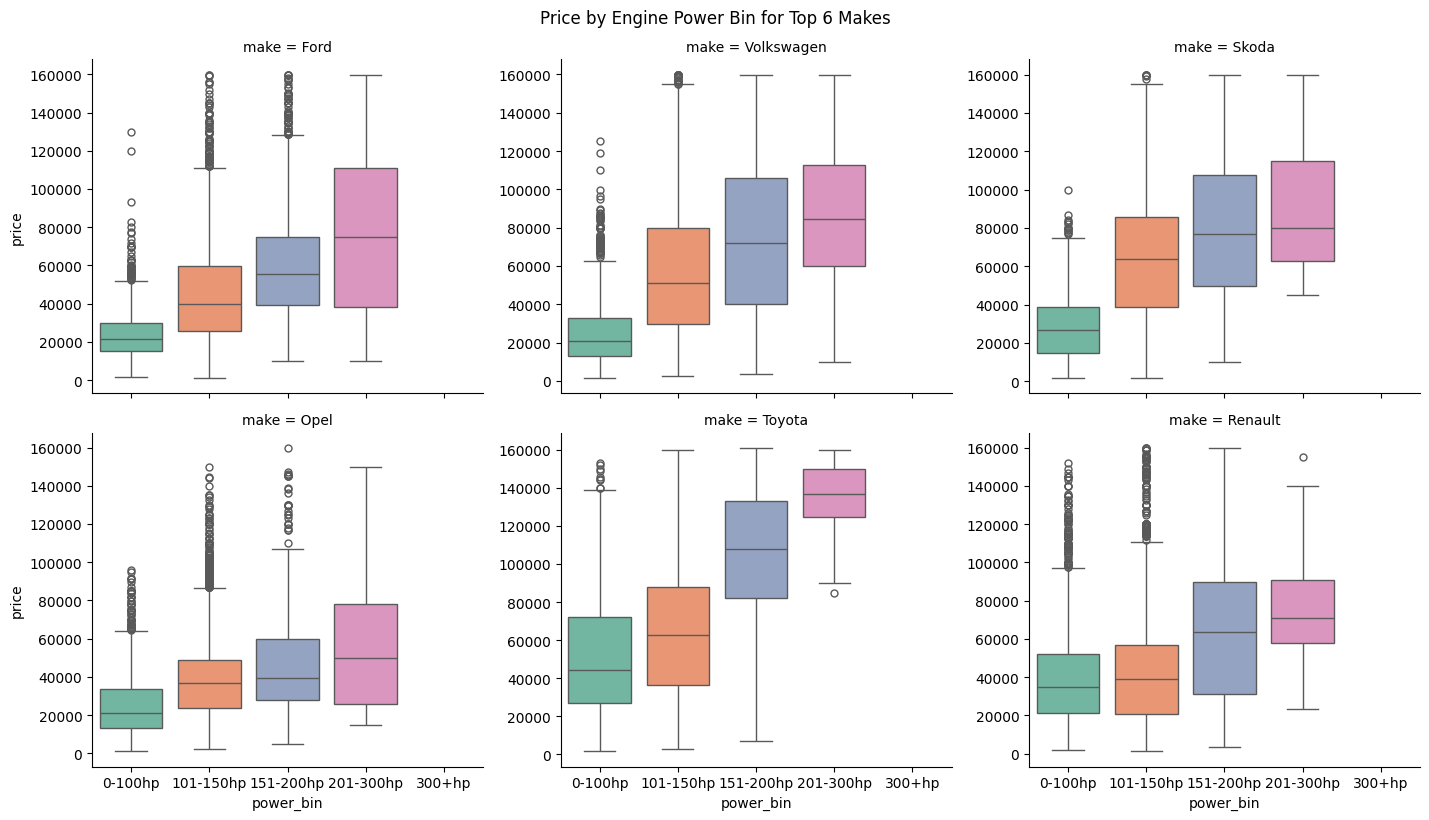

In [48]:
filtered_data["power_bin"] = pd.cut(
    filtered_data["engine_power"],
    bins=[0, 100, 150, 200, 300, np.inf],
    labels=["0-100hp", "101-150hp", "151-200hp", "201-300hp", "300+hp"]
)

pivot = filtered_data.pivot_table(
    index="make",
    columns="power_bin",
    values="price",
    aggfunc='mean',
    observed=False
)

print("Average Price by Make and Engine Power Bin:\n")
print(pivot.head(10)) 

top_6_makes = filtered_data['make'].value_counts().head(6).index
subset2 = filtered_data[filtered_data['make'].isin(top_6_makes)]
g = sns.catplot(
    data=subset2,
    x="power_bin",
    y="price",
    col="make",
    kind="box",
    hue="power_bin",
    legend=False,  
    col_wrap=3,
    sharey=False,
    height=4,
    aspect=1.2,
    palette="Set2"
)

g.fig.suptitle("Price by Engine Power Bin for Top 6 Makes", y=1.02)
plt.show()

**Engine Power vs. Price Trend**
- There is a positive slope from left (low HP) to right (high HP). The effect can vary by brand: for some (e.g., Toyota), jumping from ~150hp to ~200hp sees a significant price jump, possibly because Toyota’s higher‐power engines are in premium models.
- At comparable horsepower bins, some brands (Volkswagen, Skoda) show higher prices than others (Opel, Renault). This suggests brand perception,or equipment might be factored into used‐car valuations.
- A small number of “special edition” or “sporty” trims can drive the boxplot’s upper whisker or outliers. Some special version like GTI can dramatically push up the top price.

These plots brings us some revelations:
- Instead of treating **brand and horsepower separately**, we could create a **feature** like:
- This might improve **model accuracy in predicting car prices**.

**Why Binning by Brand Might Be Better Than Global Bins?**

Instead of hardcoded bins (0–100hp, 101–150hp, etc.), we compute brand-specific horsepower quantiles (e.g., low, medium, high per brand).

Different brands have different expectations:
- A **120hp engine** is considered “sporty” for a **Fiat**, but entry-level for a **BMW**.
- A **300hp engine** is luxury-level for a **Toyota**, but mid-range for a **Porsche**.
- **Global bins** (e.g., “0–100hp”, “101–150hp”) might not capture this nuance.

Binning horsepower inside each brand ensures we capture **relative performance** (e.g., low, medium, high power for that specific brand).  
A **high-power Ford** shouldn’t necessarily be in the same bin as a **high-power BMW**, because BMW’s fleet is much more powerful overall.


### Binning engine power by brands

In [49]:
# custom quantiles 
quantiles = [0, 0.33, 0.66, 1.0]

def assign_hp_bin(group):
    bins = np.quantile(group["engine_power"], quantiles)
    labels = ["Low", "Medium", "High"]
    return pd.cut(group["engine_power"], bins=bins, labels=labels, include_lowest=True)

filtered_data["brand_hp_bin"] = (
    filtered_data.groupby("make", group_keys=False)
    .apply(assign_hp_bin, include_groups=False)
)
brand_hp_distribution = filtered_data.groupby(["make", "brand_hp_bin"], observed=False).size().unstack()
print(brand_hp_distribution)


brand_hp_bin    Low  Medium  High
make                             
Audi           2695    1172  1846
BMW            2444    1490  1570
Citroën        1261    1424   943
Ford           3233    4111  2057
Hyundai        1794    1987  1449
Kia            1882    1919  1714
Mercedes-Benz  1276    1108  1168
Nissan         1420    1061   979
Opel           3424    4374  2003
Peugeot        1791    1762  1613
Renault        1919    2080  1808
Skoda          2090    2872  1247
Toyota         2094    2370  1833
Volkswagen     3208    3908  1980
Volvo          1370    1599   704


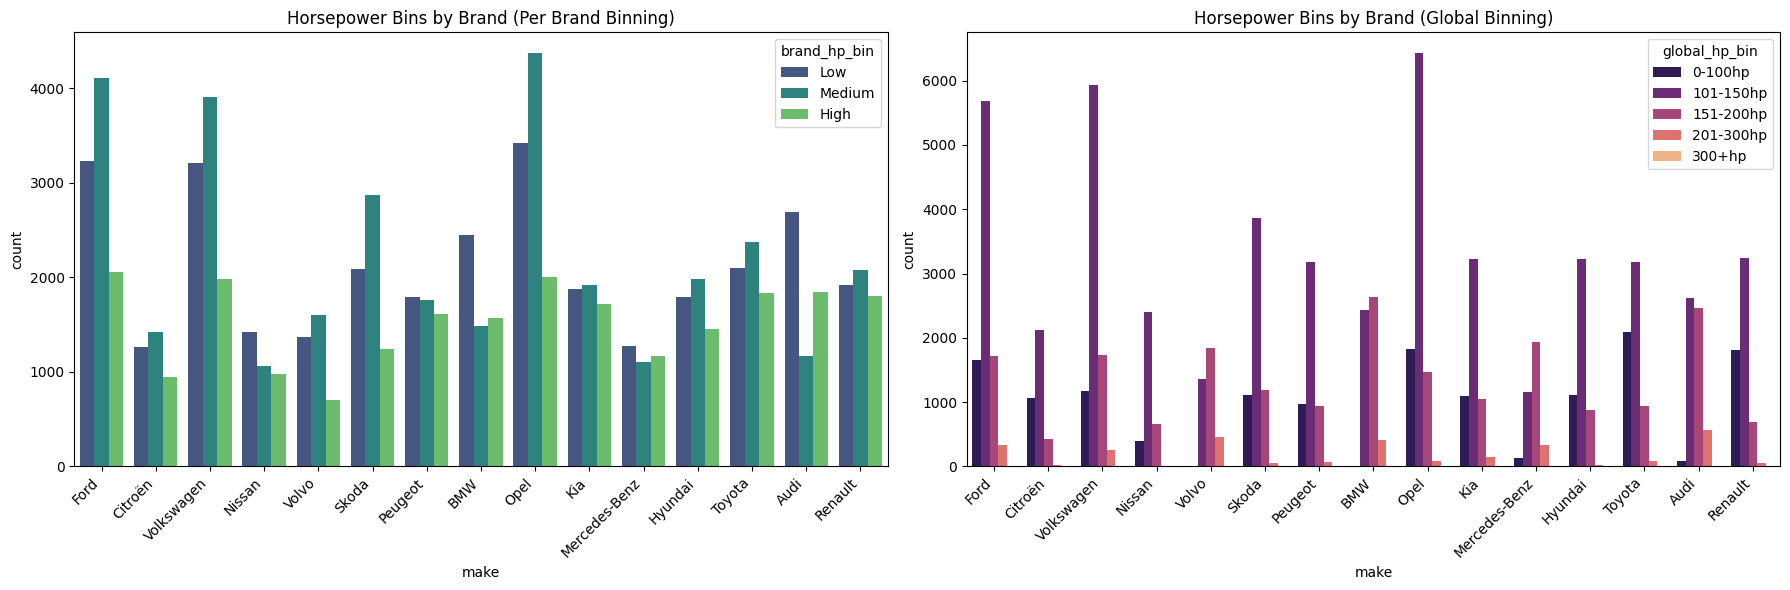

In [50]:
# Global Horsepower Bins
global_hp_bins = [0, 100, 150, 200, 300, np.inf]
global_hp_labels = ["0-100hp", "101-150hp", "151-200hp", "201-300hp", "300+hp"]

filtered_data["global_hp_bin"] = pd.cut(
    filtered_data["engine_power"], 
    bins=global_hp_bins, 
    labels=global_hp_labels, 
    include_lowest=True
)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# LEFT: Horsepower Bins by Brand
sns.countplot(
    data=filtered_data, 
    x="make", 
    hue="brand_hp_bin", 
    palette="viridis", 
    ax=axes[0]
)
axes[0].set_xticks(range(len(filtered_data["make"].unique()))) 
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
axes[0].set_title("Horsepower Bins by Brand (Per Brand Binning)")

# RIGHT: Horsepower Bins Globally
sns.countplot(
    data=filtered_data, 
    x="make", 
    hue="global_hp_bin", 
    palette="magma", 
    ax=axes[1]
)
axes[1].set_xticks(range(len(filtered_data["make"].unique())))
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
axes[1].set_title("Horsepower Bins by Brand (Global Binning)")

plt.tight_layout()
plt.show()


Observations from Horsepower Binning Analysis

- Unlike the global binning (right plot), the left plot shows variations in HP distribution across brands.
- Some brands have a more even distribution between low, medium, and high HP bins, while others show dominance in specific bins.

**Right Plot: Global Horsepower Binning**
**Overrepresentation of Low-Power Cars (0-150 HP)**
- The dataset shows a **dominance of low-power cars** in the **0-150 HP range**.
- This suggests that most cars fall into the **low-to-mid HP category**, which may **not be an accurate reflection of the real-world distribution**.
- A **150 HP Audi and a 150 HP Toyota** fall into the **same HP category** despite being in **completely different market segments**, which obviously influences price.

 A **more meaningful classification** might also consider:
  - **Weight, torque, drivetrain (FWD, RWD, AWD)**
  - **Vehicle segment (economy, luxury, sports, SUV, truck, etc.)**

If such dataset was available.


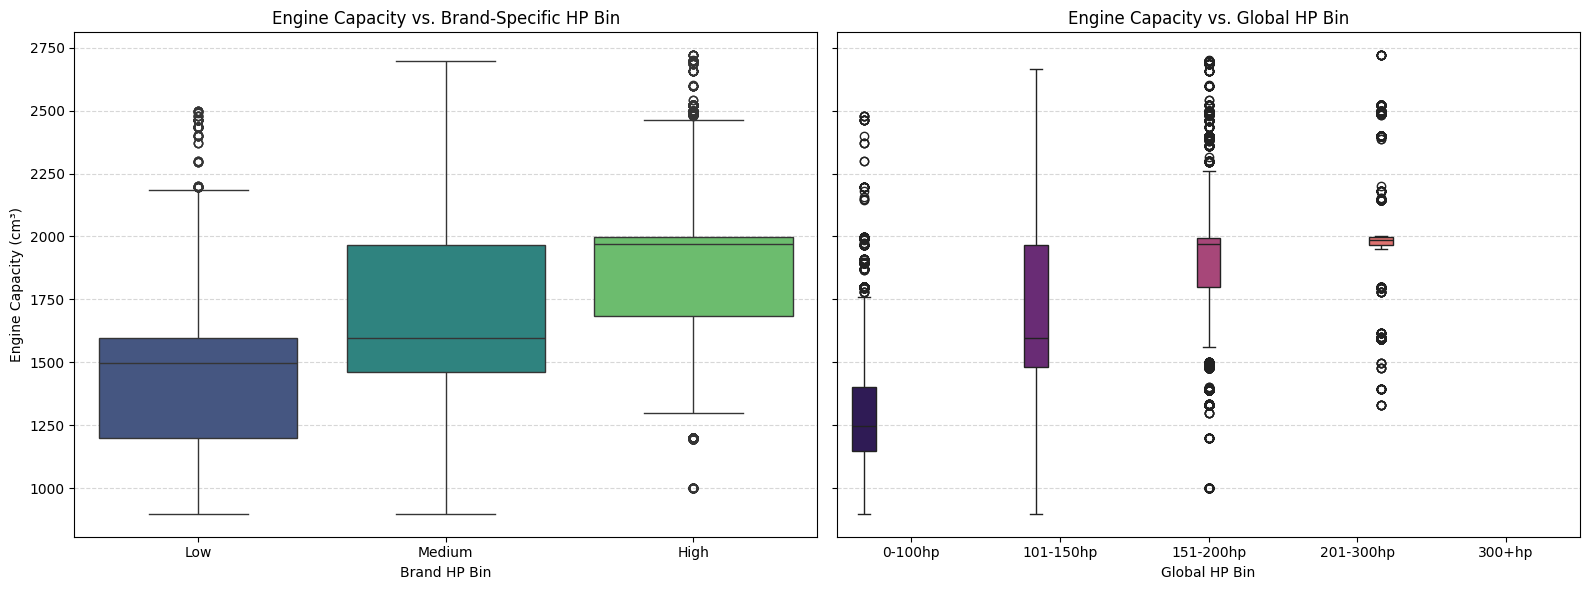

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Box Plot: Engine Capacity vs. Brand HP Bin
sns.boxplot(
    data=filtered_data,
    x="brand_hp_bin",
    y="engine_capacity",
    hue="brand_hp_bin", 
    palette="viridis",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Engine Capacity vs. Brand-Specific HP Bin")
axes[0].set_xlabel("Brand HP Bin")
axes[0].set_ylabel("Engine Capacity (cm³)")
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Box Plot: Engine Capacity vs. Global HP Bin
sns.boxplot(
    data=filtered_data,
    x="global_hp_bin",
    y="engine_capacity",
    hue="global_hp_bin", 
    palette="magma",
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Engine Capacity vs. Global HP Bin")
axes[1].set_xlabel("Global HP Bin")
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

**Engine Capacity and Horsepower: Brand-Specific vs. Global Binning**  

Engine capacity aligns more clearly with horsepower when **binned by brand**.  
- Within **brand-specific bins**, each category (**Low, Medium, High**) shows a smoother transition in engine size.  
- Manufacturers follow **specific capacity ranges** for each power level, leading to a **structured relationship** between HP and displacement.  
- In contrast, the **global HP bin** introduces a wider spread, especially in the **151-200 HP** and **201-300 HP** ranges, showing that **engine capacity does not always scale linearly** with horsepower across brands.  

**What Does This Mean?**  

Manufacturers optimize capacity **differently**.  
- **Engine capacity is not independent**—it depends on **manufacturer-specific design choices**.  
- Some **150 HP cars** have **drastically different engine capacities** due to:  
  - **Turbocharged engines** (**small displacement, high HP**)  
  - **Naturally aspirated engines** (**large displacement, moderate HP**)  
  - **Hybrid systems** (**small displacement, high output**)  

**Impact on Models - price prediction**  

- Using **HP without considering brand** could lead to **loss of crucial design-based pricing insights**.  
- Since **engine capacity follows a structured trend** within **brand bins**, we should:  
  - Use **brand-specific HP bins** for **better price prediction accuracy**.  
  - Avoid **global HP bins**, as they introduce **excessive variability in engine capacity**, reducing **predictive power**.  
  - Treat **engine size as relative to the brand**, rather than a **universal metric**.  


### ScatterPlot: Brand HP Bin & Engine Capacity vs. Price

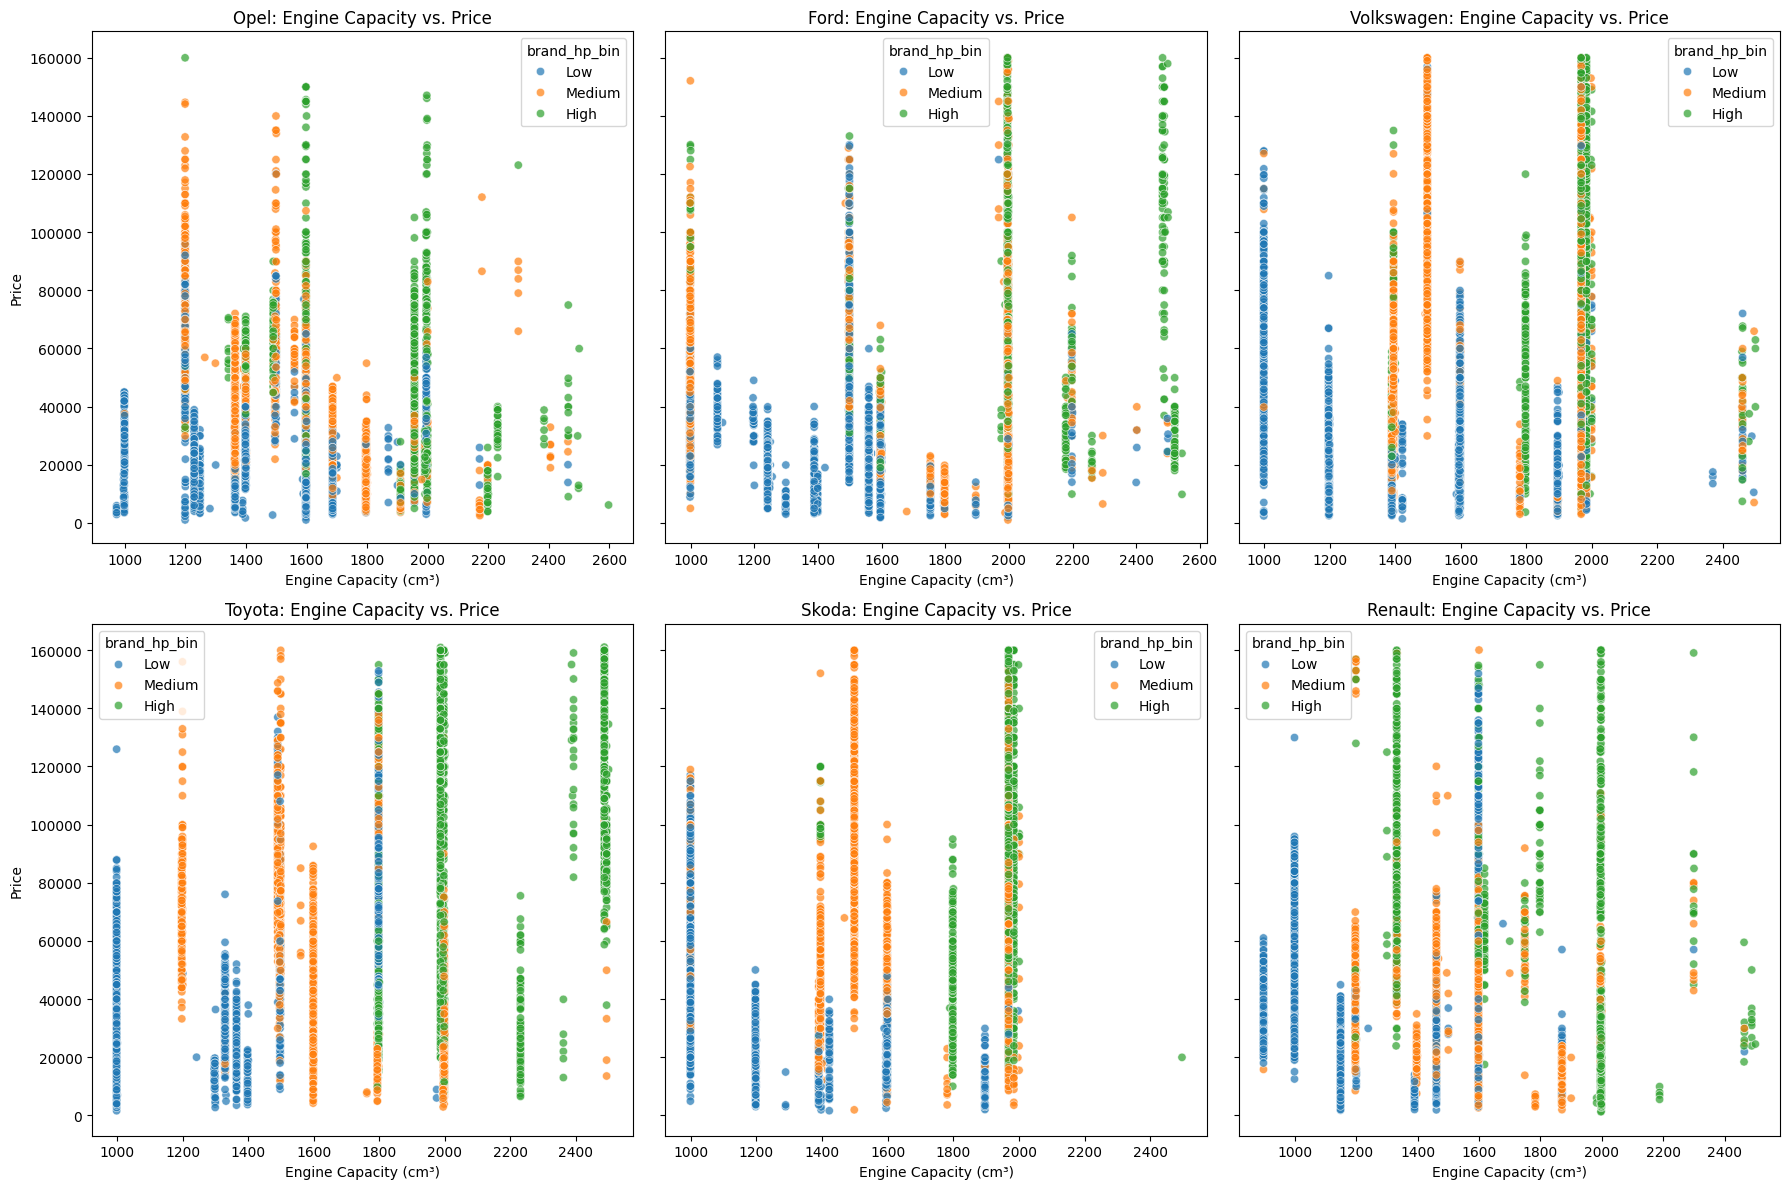

In [52]:
top_6_brands = filtered_data['make'].value_counts().index[:6]
filtered_top_brands = filtered_data[filtered_data['make'].isin(top_6_brands)]

# Brand HP Bin & Engine Capacity vs. Price
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

for ax, brand in zip(axes.flatten(), top_6_brands):
    brand_data = filtered_top_brands[filtered_top_brands['make'] == brand]
    sns.scatterplot(data=brand_data, x='engine_capacity', y='price', hue='brand_hp_bin', ax=ax, alpha=0.7)
    ax.set_title(f'{brand}: Engine Capacity vs. Price')
    ax.set_xlabel('Engine Capacity (cm³)')
    ax.set_ylabel('Price')

plt.tight_layout()
plt.show()


**Engine Capacity vs. Price (by Brand HP Bin)**
- Across all brands, **high HP cars (green)** are consistently priced higher than **medium (orange) and low HP (blue)** cars.  
- This suggests that **engine capacity and horsepower strongly influence pricing**, even within the same brand.  

### ScatterPlot: Brand HP Bin & Year vs. Price

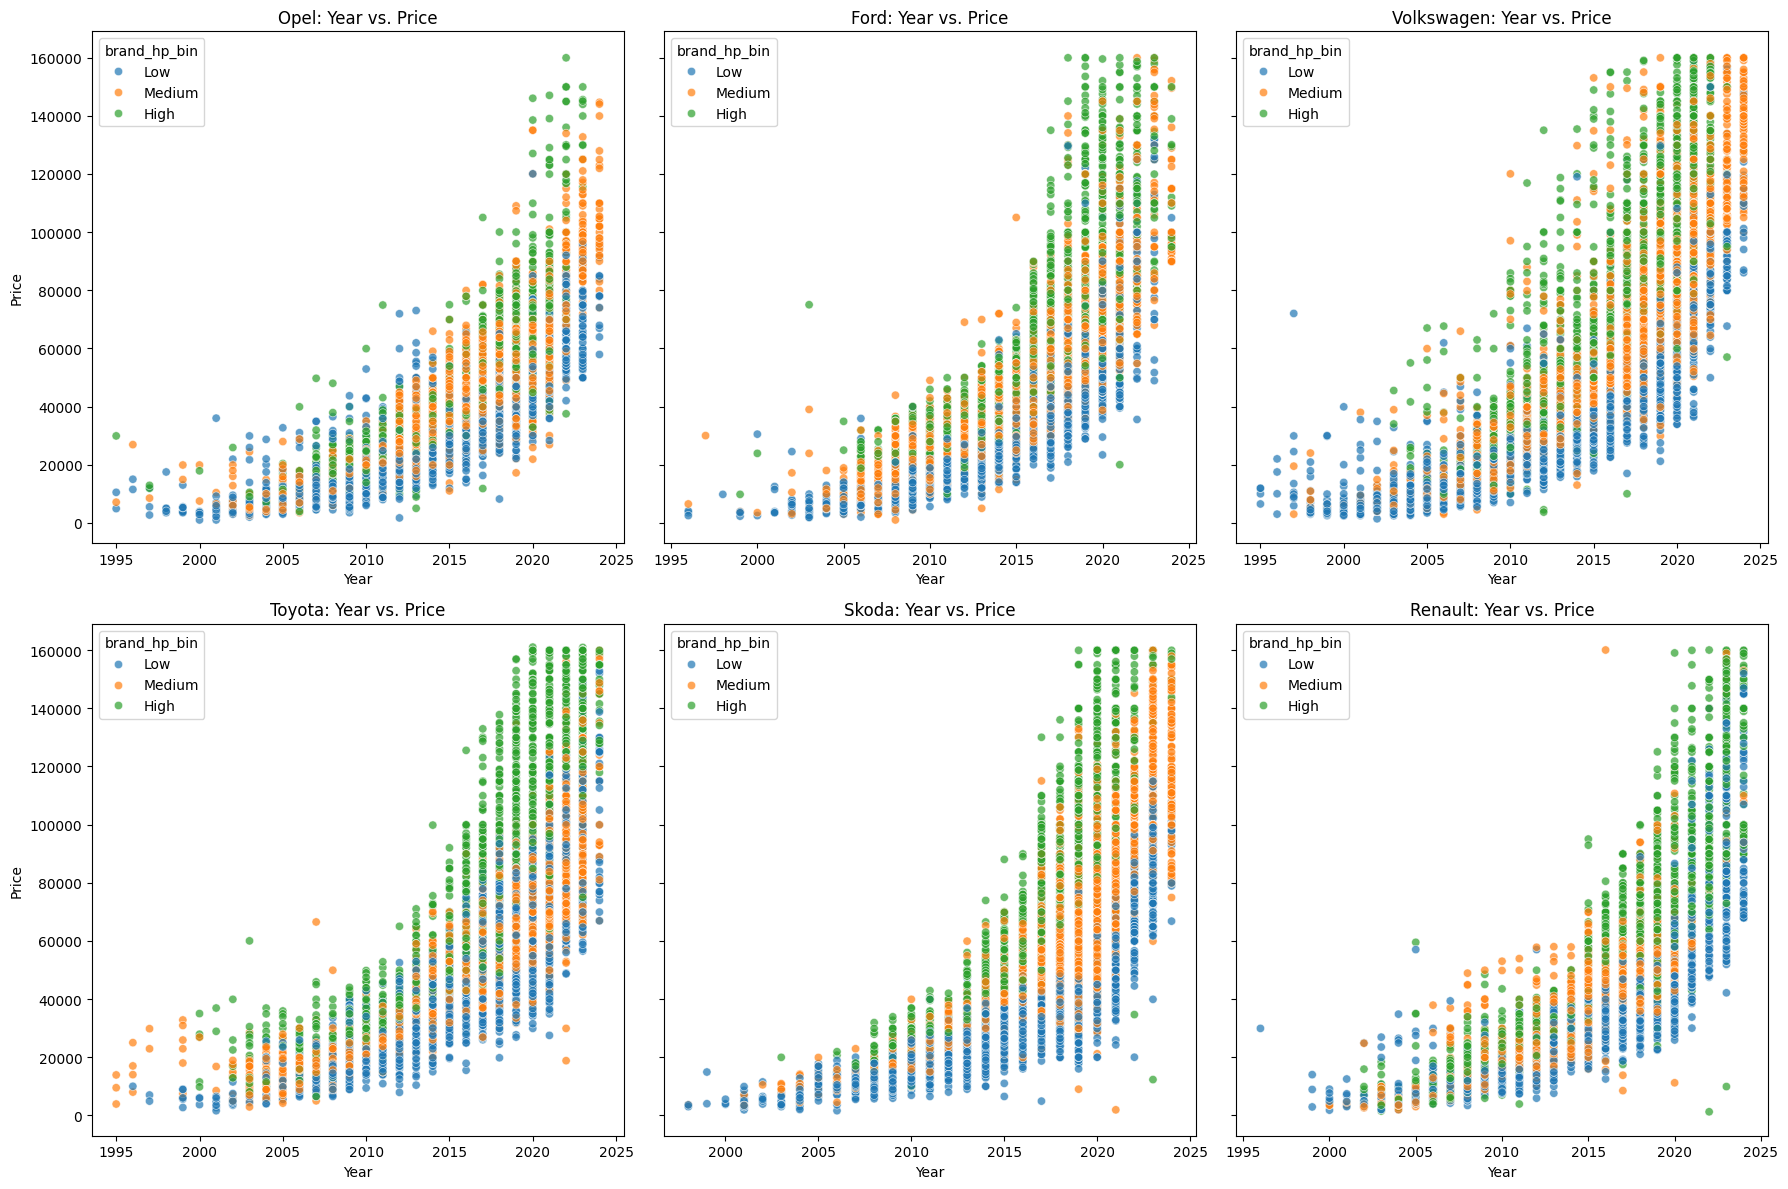

In [ ]:
# scatterplot Brand HP Bin & Year vs. Price
fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey=True)

for ax, brand in zip(axes.flatten(), top_6_brands):
    brand_data = filtered_top_brands[filtered_top_brands['make'] == brand]
    sns.scatterplot(data=brand_data, x='year', y='price', hue='brand_hp_bin', ax=ax, alpha=0.7)
    ax.set_title(f'{brand}: Year vs. Price')
    ax.set_xlabel('Year')
    ax.set_ylabel('Price')

plt.tight_layout()
plt.show()

**Year vs. Price (by Brand HP Bin)**
- **High HP cars (green) maintain higher prices** compared to medium and low HP vehicles, regardless of age.  
- **Cars from 2020+ show more uniform pricing**, likely due to standardized pricing by sellers.  
- **Older cars (pre-2000s) experience steeper depreciation**, confirming a clear depreciation curve over time.  


**HP + Year: High HP Retains More Value!**
- Even as cars age, **higher HP models hold their value better**, making them a more stable investment.

### ScatterPlot: Mileage vs Price, split by brand hp bin

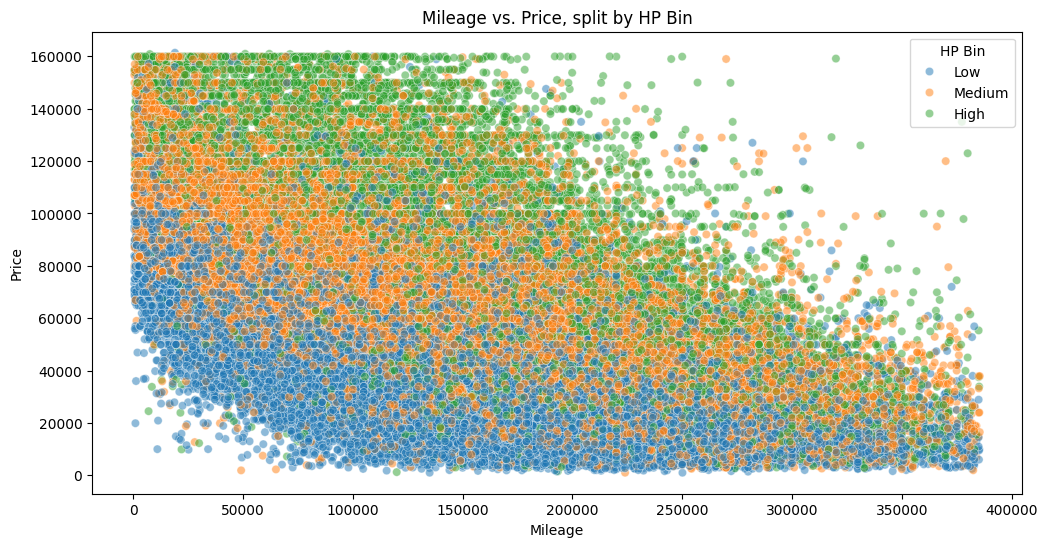

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))

# Scatter plot with hue for brand_hp_bin
sns.scatterplot(data=filtered_data, x="mileage", y="price", hue="brand_hp_bin", alpha=0.5, ax=ax)

ax.set_xlabel("Mileage")
ax.set_ylabel("Price")
ax.set_title("Mileage vs. Price, split by HP Bin")
ax.legend(title="HP Bin")

plt.show()

**Mileage vs. Price: The Depreciation Trend** 

There's a clear downward trend—higher mileage leads to lower prices, but **car power still plays a role**:  

- **Low HP cars (blue) depreciate the fastest**, consistently occupying the lower bound of prices at any mileage level.  
- **Medium HP cars (orange) sit in the middle**, following a moderate depreciation rate.  
- **High HP cars (green) retain the highest prices**, even at high mileage, showing stronger value retention.  

**Mileage Becomes the Dominant Factor Over Time**

- As mileage increases, **price variance shrinks**, meaning mileage dominates price more as cars age.  
- **Mileage should be a primary predictor of price**, next to the year (age).  
- **The steeper the slope, the greater the impact of mileage on price**.  
- **High HP cars retain value better**, meaning mileage affects them less dramatically compared to low HP cars.  


### Brand-Specific Depreciation Analysis

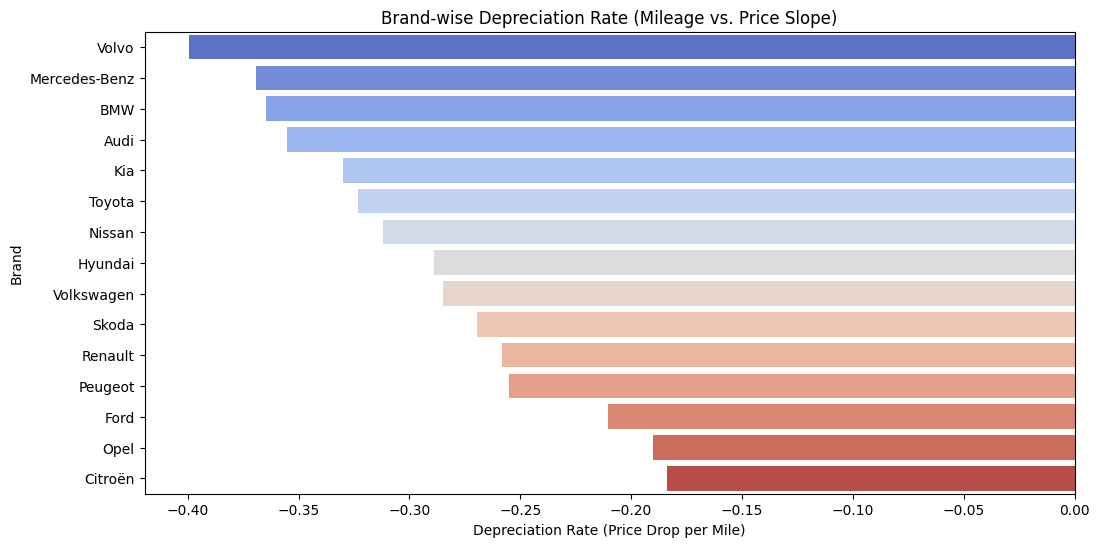

In [55]:
#  depreciation slope per brand using linear regression
depreciation_slopes = {}
for brand in brands:
    subset = filtered_data[filtered_data["make"] == brand]
    slope = np.polyfit(subset["mileage"], subset["price"], 1)[0] 
    depreciation_slopes[brand] = slope

depreciation_df = pd.DataFrame(depreciation_slopes.items(), columns=["Brand", "Depreciation Slope"])
depreciation_df = depreciation_df.sort_values(by="Depreciation Slope")

# Plot the depreciation rates
plt.figure(figsize=(12, 6))
sns.barplot(data=depreciation_df, x="Depreciation Slope", y="Brand", hue="Brand", palette="coolwarm", legend=False)
plt.title("Brand-wise Depreciation Rate (Mileage vs. Price Slope)")
plt.xlabel("Depreciation Rate (Price Drop per Mile)")
plt.ylabel("Brand")
plt.show()

**Depreciation** is calculated using linear regression (`np.polyfit`), which fits a line to the data. Since price decreases as mileage increases, the slope is naturally negative.  
- A **larger negative value** (closer to -0.40) means the car **loses value faster** with mileage.  
- A **smaller negative value** (closer to 0) means the car **retains value better** over time.  

**Key Insights**
- Volvo depreciates the fastest  
- This is surprising since Volvo is perceived as a premium brand, but it may be due to high new-car prices and relatively lower used-car demand.  

**Mercedes-Benz, BMW, and Audi also depreciate quickly**
- Luxury cars tend to have **steep depreciation**, likely due to high maintenance costs and leasing-driven new car sales.  
- Buyers may prefer **new models over high-mileage ones**, leading to rapid price drops.  

**Citroën, Opel, and Ford retain value the best**  
- Their depreciation rates are closest to zero, meaning they **lose value more slowly** with mileage.  
- These brands may have **strong demand in the used-car market**, or they start with **lower new-car prices**, making depreciation appear less severe. 

### Model-Specific Depreciation Analysis

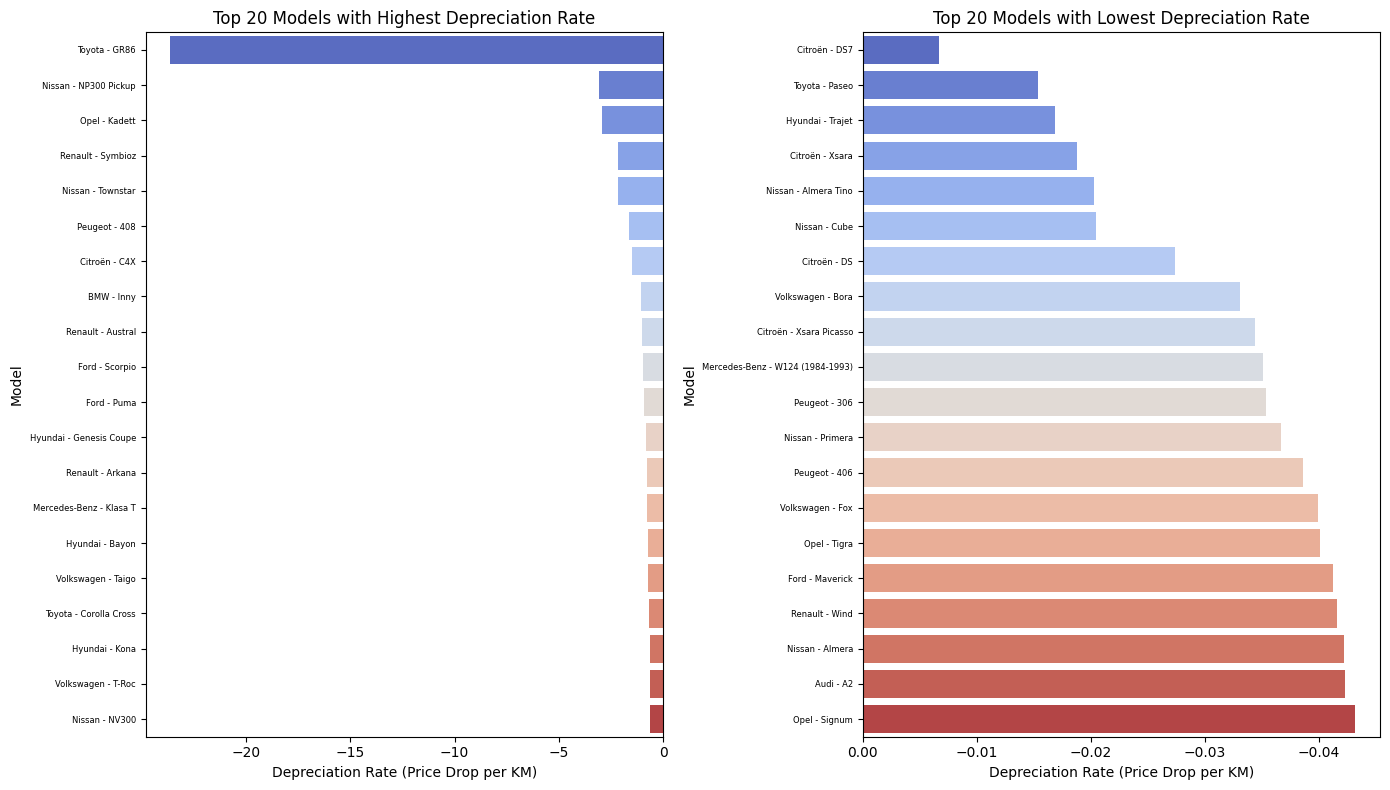

In [56]:
def calc_depreciation(group):
    if group["mileage"].max() == group["mileage"].min():
        return np.nan  #  NaN for zero mileage variation
    return (group["price"].min() - group["price"].max()) / (group["mileage"].max() - group["mileage"].min())

model_depreciation_rates = (
    filtered_data.groupby(["make", "model"], group_keys=False)
    .apply(calc_depreciation,include_groups=False)
    .reset_index(name="depreciation_rate")
)

model_depreciation_rates = model_depreciation_rates.dropna()
model_depreciation_rates = model_depreciation_rates[model_depreciation_rates["depreciation_rate"] != 0]

top_20_highest = model_depreciation_rates.sort_values(by="depreciation_rate", ascending=True).head(20)
top_20_lowest = model_depreciation_rates.sort_values(by="depreciation_rate", ascending=False).head(20)

top_20_highest["make_model"] = top_20_highest["make"] + " - " + top_20_highest["model"]
top_20_lowest["make_model"] = top_20_lowest["make"] + " - " + top_20_lowest["model"]

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

sns.barplot(
    data=top_20_highest,
    x="depreciation_rate",
    y="make_model",
    hue="make_model",  
    palette="coolwarm",
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Top 20 Models with Highest Depreciation Rate")
axes[0].set_xlabel("Depreciation Rate (Price Drop per KM)")
axes[0].set_ylabel("Model")
axes[0].tick_params(axis='y', labelsize=6)

sns.barplot(
    data=top_20_lowest,
    x="depreciation_rate",
    y="make_model",
    hue="make_model", 
    palette="coolwarm",
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Top 20 Models with Lowest Depreciation Rate")
axes[1].set_xlabel("Depreciation Rate (Price Drop per KM)")
axes[1].set_ylabel("Model")
axes[1].tick_params(axis='y', labelsize=6)

# Invert x-axis to indicate that values closer to zero are better
axes[1].invert_xaxis()

plt.tight_layout()
plt.show()

**Model-Specific Depreciation Analysis**

- **Toyota GR86 depreciates the fastest**  
    - This might make it a bad investment if value retention is a concern. Sports cars and performance-oriented models often see rapid depreciation due to limited buyer demand in the used market.  

- **The top-most models (e.g., Citroën DS7, Toyota Paseo) retain their value best.**
    - Bottom-most models (e.g., **Opel Signum, Audi A2**) depreciate more than those above them but are still among the lowest depreciating cars.
    - These models are possibly a strong long-term value retention car, likely due to reliability, affordability, and consistent demand in the second-hand market in Poland.  

- **General Trend**  
    - Luxury and new cars tend to lose value quickly, often due to high initial pricing, leasing cycles, and expensive maintenance costs.  
    - Economical and reliable cars hold their value better, making them smarter choices for long-term ownership.  

# Model

## Car Price Prediction Model using Random Forest


**Data Preparation**  
We use two datasets (`dataset_A` and `dataset_B`) that are the same but this is a standard practice to compare those two, and select relevant features for comparing model performance.  

**Selected Features**  
- **Numerical Features**:  
  - `car_age`: Age of the car in years  
  - `mileage`: Total mileage driven  
  - `engine_capacity`: Engine size in cm³  
  - `engine_power`: Engine horsepower  
  - `mileage_per_year`: Average mileage per year  

- **Categorical Features**:  
  - `make`: Car brand  
  - `model`: Specific car model  
  - `fuel_type`: Type of fuel used  
  - `gearbox`: Transmission type (manual/automatic)  
  - `color`: Car color  
  - `brand_hp_bin`: Brand-specific horsepower bin  

Missing values in selected features and `price` are dropped before proceeding.

**Train/Test Split**  
- Both datasets are split into **80% training** and **20% testing** using `train_test_split()`.  
- **Target Variable**: `price`  
  _(`np.log1p(price)` is used for comparison of transformation.)_  


**Model Pipelines**  
Two **scikit-learn pipelines** are for preprocessing and modeling, one for each dataset.

**Preprocessing Steps**  
- **Numerical Features**: Standardized using `StandardScaler()`.  
- **Categorical Features**: Encoded using `OneHotEncoder(handle_unknown="ignore")`.  
- **ColumnTransformer** is used to apply transformations.  

**Regressors**  
- **Model A**: `RandomForestRegressor()` trained on `dataset_A`  
- **Model B**: `RandomForestRegressor()` trained on `dataset_B`  


** Model Training & Evaluation**  
- Each pipeline is **fitted** on its respective training data.  
- Predictions are made on the test sets.  
- **Performance Metrics** are compared between models:  
  - **R² Score**: Measures how well the model explains variance in price.  
  - **MAE (Mean Absolute Error)**: Average absolute difference between actual and predicted prices.  
  - **RMSE (Root Mean Squared Error)**: Measures overall prediction error.  


## Comparison

In [63]:

df = filtered_data.copy()

# 1) Final features
selected_features = [
    'make', 'model', 'fuel_type', 'gearbox', 'color',
    'car_age', 'mileage', 'engine_capacity', 'engine_power',
    'mileage_per_year', 'brand_hp_bin'
]

df = df.dropna(subset=selected_features + ['price']).copy()

X = df[selected_features]
y = df['price']
y_log = np.log1p(df['price'])  

# 2) Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 3) Preprocessing
numeric_features = ['car_age', 'mileage', 'engine_capacity', 'engine_power', 'mileage_per_year']
categorical_features = ['make', 'model', 'fuel_type', 'gearbox', 'color', 'brand_hp_bin']

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

# 4) Build two models (Regular & Log1p)
model = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor(random_state=42))])
model_log = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", RandomForestRegressor(random_state=42))])

# 5) Train both models
model.fit(X_train, y_train)
model_log.fit(X_train_log, y_train_log)

# 6) Predict
y_pred = model.predict(X_test)
y_pred_log = np.expm1(model_log.predict(X_test_log)) 

# 7) Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

r2_log = r2_score(y_test, y_pred_log)
mae_log = mean_absolute_error(y_test, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))

# 8)  comparison
print("---- Standard Model ----")
print(f"R² Score:   {r2:.4f}")
print(f"MAE:        {mae:,.2f}")
print(f"RMSE:       {rmse:,.2f}")

print("\n---- Log1p Transformed Model ----")
print(f"R² Score:   {r2_log:.4f}")
print(f"MAE:        {mae_log:,.2f}")
print(f"RMSE:       {rmse_log:,.2f}")


KeyboardInterrupt: 

---- Standard Model ---- \
R² Score:   0.9422 \
MAE:        5,530.87 \
RMSE:       8,542.61 

---- Log1p Transformed Model ---- \
R² Score:   0.9393 \
MAE:        5,613.80 \
RMSE:       8,752.76 

**Model Comparison - My results**

### Standard Model


- **R² Score:** 0.9422  
- **MAE:** 5,530.87  
- **RMSE:** 8,542.61  

### Log1p Transformed Model


- **R² Score:** 0.9393  
- **MAE:** 5,613.80  
- **RMSE:** 8,752.76  

The **Log1p transformation** does not improve the models performance in this case.

The **Standard Model** is the better choice here, as it provides:
- **higher accuracy** (higher R²), 
- **lower errors** (lower MAE & RMSE), and does not introduce unnecessary transformation complexity. 
- The Log1p transformation might not be beneficial in this case, despite **my previous claims**.

# Did I overfit my model? k-fold Cross-Validation 

- An option to check for overfitting is to use **k-fold cross-validation**.
- This splits training data into k folds (subsets). 
- For each fold, the model is trained on \( k-1 \) folds and validated on the remaining fold. 
- This process repeats for each fold, and the results are averaged.

In [62]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print("Cross-validation R² scores (Standard Model):", scores)
print("Mean R²:", scores.mean(), "Std R²:", scores.std())

scores_log = cross_val_score(model_log, X_train_log, y_train_log, cv=5, scoring='r2')
print("Cross-validation R² scores (Log Model):", scores_log)
print("Mean R²:", scores_log.mean(), "Std R²:", scores_log.std())


Cross-validation R² scores (Standard Model): [0.93915687 0.94178269 0.94258747 0.93941272 0.94033645]
Mean R²: 0.9406552387311482 Std R²: 0.001333810215664575
Cross-validation R² scores (Log Model): [0.93526637 0.93638691 0.93445021 0.93511311 0.93599723]
Mean R²: 0.9354427676385031 Std R²: 0.0006817329175356861


**Cross-validation R² scores (Standard Model)**: [0.93915687 0.94178269 0.94258747 0.93941272 0.94033645] \
**Mean R²**: 0.9406552387311482 **Std R²**: 0.001333810215664575

- Each individual R² score (the numbers in the array) is close to **0.94**, meaning the model explains around **94%** of the variation in the target data for each fold.  
- The **mean R²** (≈0.9407) indicates the **average** performance across all folds.  
- The **standard deviation** (≈0.0013) is **very low**, indicating that the model’s performance is **stable** and doesn’t fluctuate much between different train/test splits.

This seems like a **highly accurate** and **reliable** model under this current cross-validation that is not an over-fit.

**Cross-validation R² scores (Log Model)**: [0.93526637 0.93638691 0.93445021 0.93511311 0.93599723]  
**Mean R²**: 0.9354427676385031 **Std R²**: 0.0006817329175356861  

- Each individual R² score is close to **0.935**, meaning the model explains around **93.5%** of the variation in the target data for each fold.  
- The **mean R²** (≈0.9354) is slightly lower than the standard model’s mean R² (≈0.9407), suggesting that the log-transformed model performs marginally worse in terms of explained variance.  
- The **standard deviation** (≈0.00068) is **very low**, even lower than the standard model’s (≈0.0013), meaning the log model is even more **consistent** and stable across different train/test splits.  

**Comparison: Standard vs. Log Model** 
- The **Standard Model** performs slightly better on average (**0.9407 vs. 0.9354**), meaning it captures more variance.  
- The **Log Model** is **more stable** (lower standard deviation), meaning it generalizes slightly better in terms of consistency.  

**Conclusion** 
If maximizing accuracy is the priority, the **Standard Model** is preferable. 

# Next Steps & Improvements

**Expanding the Dataset**
- Revisit and **expand the dataset** by including data that was previously filtered out:
  - **Older cars** (pre-1995): Capture the market for older and vintage vehicles.
  - **Brand new cars** (current year models),
  - **Cars with accident history**: Assess how past accidents impact the price,
  - **Luxurious cars**: Evaluate the pricer segment,
  - **Extreme engine capacities and power**: Focus on nice cars.

- Incorporate **additional external datasets** for richer context:
  - Other polish webpages datasets like **otomoto.pl**.
  - Economic indicators and global events relevant to car sales - COVID-19, inflation, GDP changes, fuel price spikes.
  - Datasets about car manufacturers and models popularity relevant to the polish car market among the years.



**Better Feature Engineering**
- Introduce new **domain-specific features**, including:
  - **Power-to-weight ratio**: (engine power / weight) to capture the **performance characteristics** of the vehicle.
  - **Car segment categories**: Classify cars into **categories like SUV, sedan, sports, small, luxury, etc**., for more precise modeling.
  - **Brand reliability score**: Use external datasets to integrate **brand reputation, reliability, popularity** as a feature.
  - **Previous owner count**: Evaluate the effect of **multiple owners on car depreciation** and price.
  - **Country of origin (make)**: Capture regional biases and their effects on car pricing, particularly **among Polish customers, who tend to favor certain models and companies** ("e.g., 1980s-1990s German cars like the BMW E46 and Volkswagen Golf 3 or dislike towards French cars in general, affinity towards Japan cars like Mazda, Toyota" - almost like myth busting :)).
  - **Vehicle condition (NLP analysis)**: Use natural language processing to analyze the car description text to extract info about the real state of the vehicle.
  - **Additional equipment (NLP analysis)**: Conduct NLP on car description to identify features or upgrades that differentiate a car within its model group or perhaps whole car segment.
    - Extract and quantify **extra features** (e.g. "heated seats, panoramic sunroof, touch screen, 4x4") to measure their impact on pricing.
  - **Geographical data of the seller**: Integrate region-based variables to account for local market variations, starting at closest neighboring country for each voivodeship.
  - **Country of origin (car)**: Capture regional biases and their effects on car pricing, particularly among Polish customers, who tend to favor certain countries in terms of country of origin for the car (e.g "Germany - geographical proximity and other factors"),
- **Fuel efficiency**:  Capture the impact of fuel consumption on car price, as fuel-efficient cars may retain more value as they age.
   - **Fuel price trends**:  Link historical fuel prices to demand changes (e.g., maybe demand for fuel-efficient cars rises when fuel prices increase).

**Better Analysis**
- **Clustering analysis**: Segment the cars into groups based on similarities (e.g., high-end, budget-friendly, performance, muscle, city car and more).
- **Sentiment analysis**: Understand the tone and emphasis in descriptions, which might affect buyers' perceptions (e.g. 'being in a rush - lower price, enthusiastic wording about condition - higher price, negative phrasing - lower price')
- **Add interaction features**


**Better Modeling**
- **Hyperparameter tuning** is a simple change that can yield **big improvements**, but without exploring more features this 94 % score is very good.